In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
X.shape

(41654, 71)

In [8]:
Y.shape

(41654, 4)

In [16]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=1)

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
if not os.path.exists('../data/log_reg/multiclass_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/multiclass_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/multiclass_probs.npy')

Epoch 1/700
37488/37488 [==============================] - 0s - loss: 1.3739 - acc: 0.2208     
Epoch 2/700
37488/37488 [==============================] - 0s - loss: 1.2785 - acc: 0.3948     
Epoch 3/700
37488/37488 [==============================] - 0s - loss: 1.2055 - acc: 0.5307     
Epoch 4/700
37488/37488 [==============================] - 0s - loss: 1.1509 - acc: 0.5672     
Epoch 5/700
37488/37488 [==============================] - 0s - loss: 1.1095 - acc: 0.5233     
Epoch 6/700
37488/37488 [==============================] - 0s - loss: 1.0778 - acc: 0.5180     
Epoch 7/700
37488/37488 [==============================] - 0s - loss: 1.0534 - acc: 0.5158     
Epoch 8/700
37488/37488 [==============================] - 0s - loss: 1.0342 - acc: 0.5156     
Epoch 9/700
37488/37488 [==============================] - 0s - loss: 1.0188 - acc: 0.5158     
Epoch 10/700
37488/37488 [==============================] - 0s - loss: 1.0060 - acc: 0.5162     
Epoch 11/700
37488/37488 [=============

37488/37488 [==============================] - 0s - loss: 0.6897 - acc: 0.7362     
Epoch 168/700
37488/37488 [==============================] - 0s - loss: 0.6892 - acc: 0.7368     
Epoch 169/700
37488/37488 [==============================] - 0s - loss: 0.6888 - acc: 0.7367     
Epoch 170/700
37488/37488 [==============================] - 0s - loss: 0.6885 - acc: 0.7368     
Epoch 171/700
37488/37488 [==============================] - 0s - loss: 0.6881 - acc: 0.7369     
Epoch 172/700
37488/37488 [==============================] - 0s - loss: 0.6877 - acc: 0.7369     
Epoch 173/700
37488/37488 [==============================] - 0s - loss: 0.6873 - acc: 0.7374     
Epoch 174/700
37488/37488 [==============================] - 0s - loss: 0.6869 - acc: 0.7376     
Epoch 175/700
37488/37488 [==============================] - 0s - loss: 0.6866 - acc: 0.7374     
Epoch 176/700
37488/37488 [==============================] - 0s - loss: 0.6862 - acc: 0.7382     
Epoch 177/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6545 - acc: 0.7470     
Epoch 333/700
37488/37488 [==============================] - 0s - loss: 0.6542 - acc: 0.7469     
Epoch 334/700
37488/37488 [==============================] - 0s - loss: 0.6541 - acc: 0.7469     
Epoch 335/700
37488/37488 [==============================] - 0s - loss: 0.6539 - acc: 0.7472     
Epoch 336/700
37488/37488 [==============================] - 0s - loss: 0.6538 - acc: 0.7471     
Epoch 337/700
37488/37488 [==============================] - 0s - loss: 0.6537 - acc: 0.7475     
Epoch 338/700
37488/37488 [==============================] - 0s - loss: 0.6536 - acc: 0.7475     
Epoch 339/700
37488/37488 [==============================] - 0s - loss: 0.6535 - acc: 0.7478     
Epoch 340/700
37488/37488 [==============================] - 0s - loss: 0.6533 - acc: 0.7474     
Epoch 341/700
37488/37488 [==============================] - 0s - loss: 0.6531 - acc: 0.7477     
Epoch 342/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6359 - acc: 0.7530     
Epoch 499/700
37488/37488 [==============================] - 0s - loss: 0.6358 - acc: 0.7527     
Epoch 500/700
37488/37488 [==============================] - 0s - loss: 0.6357 - acc: 0.7530     
Epoch 501/700
37488/37488 [==============================] - 0s - loss: 0.6356 - acc: 0.7532     
Epoch 502/700
37488/37488 [==============================] - 0s - loss: 0.6355 - acc: 0.7531     
Epoch 503/700
37488/37488 [==============================] - 0s - loss: 0.6354 - acc: 0.7528     
Epoch 504/700
37488/37488 [==============================] - 0s - loss: 0.6353 - acc: 0.7531     
Epoch 505/700
37488/37488 [==============================] - 0s - loss: 0.6353 - acc: 0.7527     
Epoch 506/700
37488/37488 [==============================] - 0s - loss: 0.6352 - acc: 0.7532     
Epoch 507/700
37488/37488 [==============================] - 0s - loss: 0.6351 - acc: 0.7531     
Epoch 508/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6236 - acc: 0.7559     
Epoch 665/700
37488/37488 [==============================] - 0s - loss: 0.6236 - acc: 0.7561     
Epoch 666/700
37488/37488 [==============================] - 0s - loss: 0.6235 - acc: 0.7562     
Epoch 667/700
37488/37488 [==============================] - 0s - loss: 0.6235 - acc: 0.7559     
Epoch 668/700
37488/37488 [==============================] - 0s - loss: 0.6234 - acc: 0.7561     
Epoch 669/700
37488/37488 [==============================] - 0s - loss: 0.6234 - acc: 0.7558     
Epoch 670/700
37488/37488 [==============================] - 0s - loss: 0.6233 - acc: 0.7560     
Epoch 671/700
37488/37488 [==============================] - 0s - loss: 0.6232 - acc: 0.7562     
Epoch 672/700
37488/37488 [==============================] - 0s - loss: 0.6232 - acc: 0.7560     
Epoch 673/700
37488/37488 [==============================] - 0s - loss: 0.6231 - acc: 0.7561     
Epoch 674/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.8152 - acc: 0.6305     
Epoch 48/700
37488/37488 [==============================] - 0s - loss: 0.8127 - acc: 0.6323     
Epoch 49/700
37488/37488 [==============================] - 0s - loss: 0.8102 - acc: 0.6329     
Epoch 50/700
37488/37488 [==============================] - 0s - loss: 0.8078 - acc: 0.6368     
Epoch 51/700
37488/37488 [==============================] - 0s - loss: 0.8055 - acc: 0.6373     
Epoch 52/700
37488/37488 [==============================] - 0s - loss: 0.8031 - acc: 0.6401     
Epoch 53/700
37488/37488 [==============================] - 0s - loss: 0.8009 - acc: 0.6428     
Epoch 54/700
37488/37488 [==============================] - 0s - loss: 0.7986 - acc: 0.6457     
Epoch 55/700
37488/37488 [==============================] - 0s - loss: 0.7965 - acc: 0.6494     
Epoch 56/700
37488/37488 [==============================] - 0s - loss: 0.7943 - acc: 0.6536     
Epoch 57/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.6751 - acc: 0.7423     
Epoch 215/700
37488/37488 [==============================] - 0s - loss: 0.6748 - acc: 0.7422     
Epoch 216/700
37488/37488 [==============================] - 0s - loss: 0.6746 - acc: 0.7418     
Epoch 217/700
37488/37488 [==============================] - 0s - loss: 0.6744 - acc: 0.7423     
Epoch 218/700
37488/37488 [==============================] - 0s - loss: 0.6742 - acc: 0.7425     
Epoch 219/700
37488/37488 [==============================] - 0s - loss: 0.6739 - acc: 0.7425     
Epoch 220/700
37488/37488 [==============================] - 0s - loss: 0.6737 - acc: 0.7423     
Epoch 221/700
37488/37488 [==============================] - 0s - loss: 0.6734 - acc: 0.7424     
Epoch 222/700
37488/37488 [==============================] - 0s - loss: 0.6733 - acc: 0.7423     
Epoch 223/700
37488/37488 [==============================] - 0s - loss: 0.6729 - acc: 0.7425     
Epoch 224/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6489 - acc: 0.7494     
Epoch 380/700
37488/37488 [==============================] - 0s - loss: 0.6488 - acc: 0.7496     
Epoch 381/700
37488/37488 [==============================] - 0s - loss: 0.6487 - acc: 0.7498     
Epoch 382/700
37488/37488 [==============================] - 0s - loss: 0.6486 - acc: 0.7493     
Epoch 383/700
37488/37488 [==============================] - 0s - loss: 0.6484 - acc: 0.7498     
Epoch 384/700
37488/37488 [==============================] - 0s - loss: 0.6484 - acc: 0.7497     
Epoch 385/700
37488/37488 [==============================] - 0s - loss: 0.6482 - acc: 0.7497     
Epoch 386/700
37488/37488 [==============================] - 0s - loss: 0.6481 - acc: 0.7499     
Epoch 387/700
37488/37488 [==============================] - 0s - loss: 0.6480 - acc: 0.7502     
Epoch 388/700
37488/37488 [==============================] - 0s - loss: 0.6479 - acc: 0.7498     
Epoch 389/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6329 - acc: 0.7549     
Epoch 546/700
37488/37488 [==============================] - 0s - loss: 0.6329 - acc: 0.7535     
Epoch 547/700
37488/37488 [==============================] - 0s - loss: 0.6328 - acc: 0.7541     
Epoch 548/700
37488/37488 [==============================] - 0s - loss: 0.6327 - acc: 0.7542     
Epoch 549/700
37488/37488 [==============================] - 0s - loss: 0.6326 - acc: 0.7544     
Epoch 550/700
37488/37488 [==============================] - 0s - loss: 0.6325 - acc: 0.7541     
Epoch 551/700
37488/37488 [==============================] - 0s - loss: 0.6325 - acc: 0.7543     
Epoch 552/700
37488/37488 [==============================] - 0s - loss: 0.6324 - acc: 0.7546     
Epoch 553/700
37488/37488 [==============================] - 0s - loss: 0.6323 - acc: 0.7538     
Epoch 554/700
37488/37488 [==============================] - 0s - loss: 0.6324 - acc: 0.7539     
Epoch 555/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 1.0025 - acc: 0.5150     
Epoch 11/700
37488/37488 [==============================] - 0s - loss: 0.9919 - acc: 0.5159     
Epoch 12/700
37488/37488 [==============================] - 0s - loss: 0.9826 - acc: 0.5180     
Epoch 13/700
37488/37488 [==============================] - 0s - loss: 0.9740 - acc: 0.5237     
Epoch 14/700
37488/37488 [==============================] - 0s - loss: 0.9660 - acc: 0.5330     
Epoch 15/700
37488/37488 [==============================] - 0s - loss: 0.9584 - acc: 0.5458     
Epoch 16/700
37488/37488 [==============================] - 0s - loss: 0.9512 - acc: 0.5518     
Epoch 17/700
37488/37488 [==============================] - 0s - loss: 0.9442 - acc: 0.5550     
Epoch 18/700
37488/37488 [==============================] - 0s - loss: 0.9376 - acc: 0.5585     
Epoch 19/700
37488/37488 [==============================] - 0s - loss: 0.9312 - acc: 0.5621     
Epoch 20/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.6849 - acc: 0.7388     
Epoch 178/700
37488/37488 [==============================] - 0s - loss: 0.6845 - acc: 0.7390     
Epoch 179/700
37488/37488 [==============================] - 0s - loss: 0.6842 - acc: 0.7391     
Epoch 180/700
37488/37488 [==============================] - 0s - loss: 0.6837 - acc: 0.7393     
Epoch 181/700
37488/37488 [==============================] - 0s - loss: 0.6833 - acc: 0.7395     
Epoch 182/700
37488/37488 [==============================] - 0s - loss: 0.6829 - acc: 0.7395     
Epoch 183/700
37488/37488 [==============================] - 0s - loss: 0.6826 - acc: 0.7397     
Epoch 184/700
37488/37488 [==============================] - 0s - loss: 0.6822 - acc: 0.7399     
Epoch 185/700
37488/37488 [==============================] - 0s - loss: 0.6819 - acc: 0.7400     
Epoch 186/700
37488/37488 [==============================] - 0s - loss: 0.6816 - acc: 0.7400     
Epoch 187/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6510 - acc: 0.7477     
Epoch 344/700
37488/37488 [==============================] - 0s - loss: 0.6508 - acc: 0.7486     
Epoch 345/700
37488/37488 [==============================] - 0s - loss: 0.6507 - acc: 0.7483     
Epoch 346/700
37488/37488 [==============================] - 0s - loss: 0.6505 - acc: 0.7483     
Epoch 347/700
37488/37488 [==============================] - 0s - loss: 0.6504 - acc: 0.7485     
Epoch 348/700
37488/37488 [==============================] - 0s - loss: 0.6503 - acc: 0.7485     
Epoch 349/700
37488/37488 [==============================] - 0s - loss: 0.6502 - acc: 0.7483     
Epoch 350/700
37488/37488 [==============================] - 0s - loss: 0.6501 - acc: 0.7487     
Epoch 351/700
37488/37488 [==============================] - 0s - loss: 0.6498 - acc: 0.7486     
Epoch 352/700
37488/37488 [==============================] - 0s - loss: 0.6498 - acc: 0.7488     
Epoch 353/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6333 - acc: 0.7530     
Epoch 509/700
37488/37488 [==============================] - 0s - loss: 0.6332 - acc: 0.7538     
Epoch 510/700
37488/37488 [==============================] - 0s - loss: 0.6331 - acc: 0.7531     
Epoch 511/700
37488/37488 [==============================] - 0s - loss: 0.6330 - acc: 0.7543     
Epoch 512/700
37488/37488 [==============================] - 0s - loss: 0.6329 - acc: 0.7534     
Epoch 513/700
37488/37488 [==============================] - 0s - loss: 0.6328 - acc: 0.7532     
Epoch 514/700
37488/37488 [==============================] - 0s - loss: 0.6328 - acc: 0.7529     
Epoch 515/700
37488/37488 [==============================] - 0s - loss: 0.6327 - acc: 0.7540     
Epoch 516/700
37488/37488 [==============================] - 0s - loss: 0.6326 - acc: 0.7535     
Epoch 517/700
37488/37488 [==============================] - 0s - loss: 0.6325 - acc: 0.7530     
Epoch 518/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6216 - acc: 0.7556     
Epoch 675/700
37488/37488 [==============================] - 0s - loss: 0.6216 - acc: 0.7557     
Epoch 676/700
37488/37488 [==============================] - 0s - loss: 0.6215 - acc: 0.7557     
Epoch 677/700
37488/37488 [==============================] - 0s - loss: 0.6215 - acc: 0.7559     
Epoch 678/700
37488/37488 [==============================] - 0s - loss: 0.6214 - acc: 0.7554     
Epoch 679/700
37488/37488 [==============================] - 0s - loss: 0.6213 - acc: 0.7558     
Epoch 680/700
37488/37488 [==============================] - 0s - loss: 0.6213 - acc: 0.7558     
Epoch 681/700
37488/37488 [==============================] - 0s - loss: 0.6212 - acc: 0.7555     
Epoch 682/700
37488/37488 [==============================] - 0s - loss: 0.6212 - acc: 0.7554     
Epoch 683/700
37488/37488 [==============================] - 0s - loss: 0.6212 - acc: 0.7559     
Epoch 684/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.7013 - acc: 0.7310     
Epoch 141/700
37488/37488 [==============================] - 0s - loss: 0.7007 - acc: 0.7329     
Epoch 142/700
37488/37488 [==============================] - 0s - loss: 0.7001 - acc: 0.7326     
Epoch 143/700
37488/37488 [==============================] - 0s - loss: 0.6996 - acc: 0.7328     
Epoch 144/700
37488/37488 [==============================] - 0s - loss: 0.6991 - acc: 0.7332     
Epoch 145/700
37488/37488 [==============================] - 0s - loss: 0.6985 - acc: 0.7334     
Epoch 146/700
37488/37488 [==============================] - 0s - loss: 0.6980 - acc: 0.7332     
Epoch 147/700
37488/37488 [==============================] - 0s - loss: 0.6975 - acc: 0.7339     
Epoch 148/700
37488/37488 [==============================] - 0s - loss: 0.6970 - acc: 0.7341     
Epoch 149/700
37488/37488 [==============================] - 0s - loss: 0.6965 - acc: 0.7338     
Epoch 150/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6571 - acc: 0.7479     
Epoch 306/700
37488/37488 [==============================] - 0s - loss: 0.6569 - acc: 0.7480     
Epoch 307/700
37488/37488 [==============================] - 0s - loss: 0.6568 - acc: 0.7482     
Epoch 308/700
37488/37488 [==============================] - 0s - loss: 0.6566 - acc: 0.7488     
Epoch 309/700
37488/37488 [==============================] - 0s - loss: 0.6565 - acc: 0.7482     
Epoch 310/700
37488/37488 [==============================] - 0s - loss: 0.6564 - acc: 0.7484     
Epoch 311/700
37488/37488 [==============================] - 0s - loss: 0.6563 - acc: 0.7483     
Epoch 312/700
37488/37488 [==============================] - 0s - loss: 0.6561 - acc: 0.7485     
Epoch 313/700
37488/37488 [==============================] - 0s - loss: 0.6560 - acc: 0.7486     
Epoch 314/700
37488/37488 [==============================] - 0s - loss: 0.6559 - acc: 0.7487     
Epoch 315/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6377 - acc: 0.7535     
Epoch 472/700
37488/37488 [==============================] - 0s - loss: 0.6376 - acc: 0.7534     
Epoch 473/700
37488/37488 [==============================] - 0s - loss: 0.6375 - acc: 0.7537     
Epoch 474/700
37488/37488 [==============================] - 0s - loss: 0.6374 - acc: 0.7542     
Epoch 475/700
37488/37488 [==============================] - 0s - loss: 0.6374 - acc: 0.7537     
Epoch 476/700
37488/37488 [==============================] - 0s - loss: 0.6373 - acc: 0.7537     
Epoch 477/700
37488/37488 [==============================] - 0s - loss: 0.6372 - acc: 0.7536     
Epoch 478/700
37488/37488 [==============================] - 0s - loss: 0.6371 - acc: 0.7539     
Epoch 479/700
37488/37488 [==============================] - 0s - loss: 0.6370 - acc: 0.7541     
Epoch 480/700
37488/37488 [==============================] - 0s - loss: 0.6370 - acc: 0.7538     
Epoch 481/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.6250 - acc: 0.7559     
Epoch 638/700
37488/37488 [==============================] - 0s - loss: 0.6249 - acc: 0.7559     
Epoch 639/700
37488/37488 [==============================] - 0s - loss: 0.6249 - acc: 0.7562     
Epoch 640/700
37488/37488 [==============================] - 0s - loss: 0.6248 - acc: 0.7561     
Epoch 641/700
37488/37488 [==============================] - 0s - loss: 0.6247 - acc: 0.7562     
Epoch 642/700
37488/37488 [==============================] - 0s - loss: 0.6247 - acc: 0.7563     
Epoch 643/700
37488/37488 [==============================] - 0s - loss: 0.6246 - acc: 0.7561     
Epoch 644/700
37488/37488 [==============================] - 0s - loss: 0.6246 - acc: 0.7561     
Epoch 645/700
37488/37488 [==============================] - 0s - loss: 0.6244 - acc: 0.7562     
Epoch 646/700
37488/37488 [==============================] - 0s - loss: 0.6244 - acc: 0.7561     
Epoch 647/700
37488/37488 [=======

37489/37489 [==============================] - 0s - loss: 0.7274 - acc: 0.7174     
Epoch 105/700
37489/37489 [==============================] - 0s - loss: 0.7264 - acc: 0.7151     
Epoch 106/700
37489/37489 [==============================] - 0s - loss: 0.7255 - acc: 0.7195     
Epoch 107/700
37489/37489 [==============================] - 0s - loss: 0.7246 - acc: 0.7173     
Epoch 108/700
37489/37489 [==============================] - 0s - loss: 0.7237 - acc: 0.7183     
Epoch 109/700
37489/37489 [==============================] - 0s - loss: 0.7228 - acc: 0.7210     
Epoch 110/700
37489/37489 [==============================] - 0s - loss: 0.7220 - acc: 0.7195     
Epoch 111/700
37489/37489 [==============================] - 0s - loss: 0.7211 - acc: 0.7199     
Epoch 112/700
37489/37489 [==============================] - 0s - loss: 0.7203 - acc: 0.7218     
Epoch 113/700
37489/37489 [==============================] - 0s - loss: 0.7195 - acc: 0.7225     
Epoch 114/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6608 - acc: 0.7477     
Epoch 271/700
37489/37489 [==============================] - 0s - loss: 0.6606 - acc: 0.7478     
Epoch 272/700
37489/37489 [==============================] - 0s - loss: 0.6605 - acc: 0.7477     
Epoch 273/700
37489/37489 [==============================] - 0s - loss: 0.6603 - acc: 0.7476     
Epoch 274/700
37489/37489 [==============================] - 0s - loss: 0.6601 - acc: 0.7479     
Epoch 275/700
37489/37489 [==============================] - 0s - loss: 0.6600 - acc: 0.7475     
Epoch 276/700
37489/37489 [==============================] - 0s - loss: 0.6598 - acc: 0.7475     
Epoch 277/700
37489/37489 [==============================] - 0s - loss: 0.6596 - acc: 0.7485     
Epoch 278/700
37489/37489 [==============================] - 0s - loss: 0.6595 - acc: 0.7476     
Epoch 279/700
37489/37489 [==============================] - 0s - loss: 0.6594 - acc: 0.7480     
Epoch 280/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6391 - acc: 0.7536     
Epoch 436/700
37489/37489 [==============================] - 0s - loss: 0.6389 - acc: 0.7534     
Epoch 437/700
37489/37489 [==============================] - 0s - loss: 0.6388 - acc: 0.7538     
Epoch 438/700
37489/37489 [==============================] - 0s - loss: 0.6387 - acc: 0.7540     
Epoch 439/700
37489/37489 [==============================] - 0s - loss: 0.6386 - acc: 0.7539     
Epoch 440/700
37489/37489 [==============================] - 0s - loss: 0.6385 - acc: 0.7541     
Epoch 441/700
37489/37489 [==============================] - 0s - loss: 0.6384 - acc: 0.7542     
Epoch 442/700
37489/37489 [==============================] - 0s - loss: 0.6383 - acc: 0.7540     
Epoch 443/700
37489/37489 [==============================] - 0s - loss: 0.6382 - acc: 0.7539     
Epoch 444/700
37489/37489 [==============================] - 0s - loss: 0.6381 - acc: 0.7541     
Epoch 445/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6253 - acc: 0.7570     
Epoch 601/700
37489/37489 [==============================] - 0s - loss: 0.6253 - acc: 0.7573     
Epoch 602/700
37489/37489 [==============================] - 0s - loss: 0.6250 - acc: 0.7574     
Epoch 603/700
37489/37489 [==============================] - 0s - loss: 0.6250 - acc: 0.7573     
Epoch 604/700
37489/37489 [==============================] - 0s - loss: 0.6250 - acc: 0.7571     
Epoch 605/700
37489/37489 [==============================] - 0s - loss: 0.6249 - acc: 0.7574     
Epoch 606/700
37489/37489 [==============================] - 0s - loss: 0.6248 - acc: 0.7575     
Epoch 607/700
37489/37489 [==============================] - 0s - loss: 0.6248 - acc: 0.7574     
Epoch 608/700
37489/37489 [==============================] - 0s - loss: 0.6247 - acc: 0.7575     
Epoch 609/700
37489/37489 [==============================] - 0s - loss: 0.6247 - acc: 0.7569     
Epoch 610/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.7708 - acc: 0.6654     
Epoch 67/700
37489/37489 [==============================] - 0s - loss: 0.7691 - acc: 0.6677     
Epoch 68/700
37489/37489 [==============================] - 0s - loss: 0.7674 - acc: 0.6702     
Epoch 69/700
37489/37489 [==============================] - 0s - loss: 0.7659 - acc: 0.6712     
Epoch 70/700
37489/37489 [==============================] - 0s - loss: 0.7643 - acc: 0.6697     
Epoch 71/700
37489/37489 [==============================] - 0s - loss: 0.7627 - acc: 0.6739     
Epoch 72/700
37489/37489 [==============================] - 0s - loss: 0.7612 - acc: 0.6730     
Epoch 73/700
37489/37489 [==============================] - 0s - loss: 0.7597 - acc: 0.6755     
Epoch 74/700
37489/37489 [==============================] - 0s - loss: 0.7583 - acc: 0.6742     
Epoch 75/700
37489/37489 [==============================] - 0s - loss: 0.7569 - acc: 0.6790     
Epoch 76/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.6948 - acc: 0.7341     
Epoch 151/700
37489/37489 [==============================] - 0s - loss: 0.6943 - acc: 0.7350     
Epoch 152/700
37489/37489 [==============================] - 0s - loss: 0.6938 - acc: 0.7353     
Epoch 153/700
37489/37489 [==============================] - 0s - loss: 0.6934 - acc: 0.7358     
Epoch 154/700
37489/37489 [==============================] - 0s - loss: 0.6930 - acc: 0.7354     
Epoch 155/700
37489/37489 [==============================] - 0s - loss: 0.6926 - acc: 0.7351     
Epoch 156/700
37489/37489 [==============================] - 0s - loss: 0.6921 - acc: 0.7358     
Epoch 157/700
37489/37489 [==============================] - 0s - loss: 0.6916 - acc: 0.7359     
Epoch 158/700
37489/37489 [==============================] - 0s - loss: 0.6912 - acc: 0.7360     
Epoch 159/700
37489/37489 [==============================] - 0s - loss: 0.6907 - acc: 0.7363     
Epoch 160/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6688 - acc: 0.7434     
Epoch 234/700
37489/37489 [==============================] - 0s - loss: 0.6686 - acc: 0.7437     
Epoch 235/700
37489/37489 [==============================] - 0s - loss: 0.6684 - acc: 0.7435     
Epoch 236/700
37489/37489 [==============================] - 0s - loss: 0.6682 - acc: 0.7437     
Epoch 237/700
37489/37489 [==============================] - 0s - loss: 0.6680 - acc: 0.7438     
Epoch 238/700
37489/37489 [==============================] - 0s - loss: 0.6678 - acc: 0.7440     
Epoch 239/700
37489/37489 [==============================] - 0s - loss: 0.6676 - acc: 0.7439     
Epoch 240/700
37489/37489 [==============================] - 0s - loss: 0.6674 - acc: 0.7441     
Epoch 241/700
37489/37489 [==============================] - 0s - loss: 0.6672 - acc: 0.7441     
Epoch 242/700
37489/37489 [==============================] - 0s - loss: 0.6672 - acc: 0.7441     
Epoch 243/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6448 - acc: 0.7498     
Epoch 399/700
37489/37489 [==============================] - 0s - loss: 0.6447 - acc: 0.7498     
Epoch 400/700
37489/37489 [==============================] - 0s - loss: 0.6446 - acc: 0.7498     
Epoch 401/700
37489/37489 [==============================] - 0s - loss: 0.6444 - acc: 0.7499     
Epoch 402/700
37489/37489 [==============================] - 0s - loss: 0.6443 - acc: 0.7498     
Epoch 403/700
37489/37489 [==============================] - 0s - loss: 0.6442 - acc: 0.7501     
Epoch 404/700
37489/37489 [==============================] - 0s - loss: 0.6441 - acc: 0.7498     
Epoch 405/700
37489/37489 [==============================] - 0s - loss: 0.6440 - acc: 0.7503     
Epoch 406/700
37489/37489 [==============================] - 0s - loss: 0.6439 - acc: 0.7497     
Epoch 407/700
37489/37489 [==============================] - 0s - loss: 0.6437 - acc: 0.7498     
Epoch 408/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6297 - acc: 0.7541     
Epoch 564/700
37489/37489 [==============================] - 0s - loss: 0.6296 - acc: 0.7541     
Epoch 565/700
37489/37489 [==============================] - 0s - loss: 0.6295 - acc: 0.7541     
Epoch 566/700
37489/37489 [==============================] - 0s - loss: 0.6294 - acc: 0.7541     
Epoch 567/700
37489/37489 [==============================] - 0s - loss: 0.6294 - acc: 0.7541     
Epoch 568/700
37489/37489 [==============================] - 0s - loss: 0.6294 - acc: 0.7543     
Epoch 569/700
37489/37489 [==============================] - 0s - loss: 0.6293 - acc: 0.7540     
Epoch 570/700
37489/37489 [==============================] - 0s - loss: 0.6292 - acc: 0.7542     
Epoch 571/700
37489/37489 [==============================] - 0s - loss: 0.6291 - acc: 0.7542     
Epoch 572/700
37489/37489 [==============================] - 0s - loss: 0.6290 - acc: 0.7544     
Epoch 573/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.8733 - acc: 0.6199     
Epoch 30/700
37489/37489 [==============================] - 0s - loss: 0.8688 - acc: 0.6155     
Epoch 31/700
37489/37489 [==============================] - 0s - loss: 0.8645 - acc: 0.6160     
Epoch 32/700
37489/37489 [==============================] - 0s - loss: 0.8604 - acc: 0.6171     
Epoch 33/700
37489/37489 [==============================] - 0s - loss: 0.8564 - acc: 0.6176     
Epoch 34/700
37489/37489 [==============================] - 0s - loss: 0.8526 - acc: 0.6133     
Epoch 35/700
37489/37489 [==============================] - 0s - loss: 0.8489 - acc: 0.6152     
Epoch 36/700
37489/37489 [==============================] - 0s - loss: 0.8453 - acc: 0.6170     
Epoch 37/700
37489/37489 [==============================] - 0s - loss: 0.8419 - acc: 0.6184     
Epoch 38/700
37489/37489 [==============================] - 0s - loss: 0.8386 - acc: 0.6200     
Epoch 39/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.6788 - acc: 0.7403     
Epoch 197/700
37489/37489 [==============================] - 0s - loss: 0.6785 - acc: 0.7405     
Epoch 198/700
37489/37489 [==============================] - 0s - loss: 0.6782 - acc: 0.7406     
Epoch 199/700
37489/37489 [==============================] - 0s - loss: 0.6779 - acc: 0.7407     
Epoch 200/700
37489/37489 [==============================] - 0s - loss: 0.6777 - acc: 0.7407     
Epoch 201/700
37489/37489 [==============================] - 0s - loss: 0.6774 - acc: 0.7408     
Epoch 202/700
37489/37489 [==============================] - 0s - loss: 0.6771 - acc: 0.7410     
Epoch 203/700
37489/37489 [==============================] - 0s - loss: 0.6769 - acc: 0.7407     
Epoch 204/700
37489/37489 [==============================] - 0s - loss: 0.6766 - acc: 0.7407     
Epoch 205/700
37489/37489 [==============================] - 0s - loss: 0.6763 - acc: 0.7410     
Epoch 206/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6504 - acc: 0.7485     
Epoch 363/700
37489/37489 [==============================] - 0s - loss: 0.6503 - acc: 0.7490     
Epoch 364/700
37489/37489 [==============================] - 0s - loss: 0.6502 - acc: 0.7489     
Epoch 365/700
37489/37489 [==============================] - 0s - loss: 0.6500 - acc: 0.7487     
Epoch 366/700
37489/37489 [==============================] - 0s - loss: 0.6499 - acc: 0.7488     
Epoch 367/700
37489/37489 [==============================] - 0s - loss: 0.6498 - acc: 0.7490     
Epoch 368/700
37489/37489 [==============================] - 0s - loss: 0.6497 - acc: 0.7489     
Epoch 369/700
37489/37489 [==============================] - 0s - loss: 0.6496 - acc: 0.7483     
Epoch 370/700
37489/37489 [==============================] - 0s - loss: 0.6494 - acc: 0.7490     
Epoch 371/700
37489/37489 [==============================] - 0s - loss: 0.6492 - acc: 0.7489     
Epoch 372/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6336 - acc: 0.7538     
Epoch 529/700
37489/37489 [==============================] - 0s - loss: 0.6335 - acc: 0.7535     
Epoch 530/700
37489/37489 [==============================] - 0s - loss: 0.6334 - acc: 0.7537     
Epoch 531/700
37489/37489 [==============================] - 0s - loss: 0.6334 - acc: 0.7537     
Epoch 532/700
37489/37489 [==============================] - 0s - loss: 0.6333 - acc: 0.7537     
Epoch 533/700
37489/37489 [==============================] - 0s - loss: 0.6332 - acc: 0.7534     
Epoch 534/700
37489/37489 [==============================] - 0s - loss: 0.6332 - acc: 0.7535     
Epoch 535/700
37489/37489 [==============================] - 0s - loss: 0.6330 - acc: 0.7533     
Epoch 536/700
37489/37489 [==============================] - 0s - loss: 0.6330 - acc: 0.7537     
Epoch 537/700
37489/37489 [==============================] - 0s - loss: 0.6329 - acc: 0.7534     
Epoch 538/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6226 - acc: 0.7545     
Epoch 695/700
37489/37489 [==============================] - 0s - loss: 0.6226 - acc: 0.7543     
Epoch 696/700
37489/37489 [==============================] - 0s - loss: 0.6225 - acc: 0.7548     
Epoch 697/700
37489/37489 [==============================] - 0s - loss: 0.6225 - acc: 0.7544     
Epoch 698/700
37489/37489 [==============================] - 0s - loss: 0.6224 - acc: 0.7542     
Epoch 699/700
37489/37489 [==============================] - 0s - loss: 0.6224 - acc: 0.7550     
Epoch 700/700
37489/37489 [==============================] - 0s - loss: 1.4044 - acc: 0.2769     
Epoch 2/700
37489/37489 [==============================] - 0s - loss: 1.2998 - acc: 0.3578     
Epoch 3/700
37489/37489 [==============================] - 0s - loss: 1.2196 - acc: 0.3619     
Epoch 4/700
37489/37489 [==============================] - 0s - loss: 1.1593 - acc: 0.5343     
Epoch 5/700
37489/37489 [===============

37489/37489 [==============================] - 0s - loss: 0.6960 - acc: 0.7341     
Epoch 161/700
37489/37489 [==============================] - 0s - loss: 0.6956 - acc: 0.7345     
Epoch 162/700
37489/37489 [==============================] - 0s - loss: 0.6951 - acc: 0.7341     
Epoch 163/700
37489/37489 [==============================] - 0s - loss: 0.6947 - acc: 0.7352     
Epoch 164/700
37489/37489 [==============================] - 0s - loss: 0.6942 - acc: 0.7350     
Epoch 165/700
37489/37489 [==============================] - 0s - loss: 0.6938 - acc: 0.7353     
Epoch 166/700
37489/37489 [==============================] - 0s - loss: 0.6933 - acc: 0.7356     
Epoch 167/700
37489/37489 [==============================] - 0s - loss: 0.6929 - acc: 0.7361     
Epoch 168/700
37489/37489 [==============================] - 0s - loss: 0.6925 - acc: 0.7364     
Epoch 169/700
37489/37489 [==============================] - 0s - loss: 0.6921 - acc: 0.7361     
Epoch 170/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6580 - acc: 0.7466     
Epoch 327/700
37489/37489 [==============================] - 0s - loss: 0.6578 - acc: 0.7467     
Epoch 328/700
37489/37489 [==============================] - 0s - loss: 0.6577 - acc: 0.7472     
Epoch 329/700
37489/37489 [==============================] - 0s - loss: 0.6575 - acc: 0.7469     
Epoch 330/700
37489/37489 [==============================] - 0s - loss: 0.6574 - acc: 0.7472     
Epoch 331/700
37489/37489 [==============================] - 0s - loss: 0.6572 - acc: 0.7470     
Epoch 332/700
37489/37489 [==============================] - 0s - loss: 0.6571 - acc: 0.7468     
Epoch 333/700
37489/37489 [==============================] - 0s - loss: 0.6571 - acc: 0.7470     
Epoch 334/700
37489/37489 [==============================] - 0s - loss: 0.6568 - acc: 0.7471     
Epoch 335/700
37489/37489 [==============================] - 0s - loss: 0.6567 - acc: 0.7470     
Epoch 336/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6394 - acc: 0.7522     
Epoch 493/700
37489/37489 [==============================] - 0s - loss: 0.6394 - acc: 0.7523     
Epoch 494/700
37489/37489 [==============================] - 0s - loss: 0.6392 - acc: 0.7527     
Epoch 495/700
37489/37489 [==============================] - 0s - loss: 0.6392 - acc: 0.7519     
Epoch 496/700
37489/37489 [==============================] - 0s - loss: 0.6390 - acc: 0.7526     
Epoch 497/700
37489/37489 [==============================] - 0s - loss: 0.6390 - acc: 0.7521     
Epoch 498/700
37489/37489 [==============================] - 0s - loss: 0.6389 - acc: 0.7522     
Epoch 499/700
37489/37489 [==============================] - 0s - loss: 0.6388 - acc: 0.7522     
Epoch 500/700
37489/37489 [==============================] - 0s - loss: 0.6387 - acc: 0.7520     
Epoch 501/700
37489/37489 [==============================] - 0s - loss: 0.6386 - acc: 0.7522     
Epoch 502/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6268 - acc: 0.7548     
Epoch 659/700
37489/37489 [==============================] - 0s - loss: 0.6268 - acc: 0.7545     
Epoch 660/700
37489/37489 [==============================] - 0s - loss: 0.6267 - acc: 0.7547     
Epoch 661/700
37489/37489 [==============================] - 0s - loss: 0.6267 - acc: 0.7545     
Epoch 662/700
37489/37489 [==============================] - 0s - loss: 0.6266 - acc: 0.7547     
Epoch 663/700
37489/37489 [==============================] - 0s - loss: 0.6265 - acc: 0.7548     
Epoch 664/700
37489/37489 [==============================] - 0s - loss: 0.6265 - acc: 0.7547     
Epoch 665/700
37489/37489 [==============================] - 0s - loss: 0.6264 - acc: 0.7547     
Epoch 666/700
37489/37489 [==============================] - 0s - loss: 0.6264 - acc: 0.7548     
Epoch 667/700
37489/37489 [==============================] - 0s - loss: 0.6263 - acc: 0.7546     
Epoch 668/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.7100 - acc: 0.7286     
Epoch 126/700
37489/37489 [==============================] - 0s - loss: 0.7093 - acc: 0.7271     
Epoch 127/700
37489/37489 [==============================] - 0s - loss: 0.7086 - acc: 0.7291     
Epoch 128/700
37489/37489 [==============================] - 0s - loss: 0.7080 - acc: 0.7297     
Epoch 129/700
37489/37489 [==============================] - 0s - loss: 0.7073 - acc: 0.7287     
Epoch 130/700
37489/37489 [==============================] - 0s - loss: 0.7068 - acc: 0.7291     
Epoch 131/700
37489/37489 [==============================] - 0s - loss: 0.7061 - acc: 0.7294     
Epoch 132/700
37489/37489 [==============================] - 0s - loss: 0.7055 - acc: 0.7287     
Epoch 133/700
37489/37489 [==============================] - 0s - loss: 0.7048 - acc: 0.7309     
Epoch 134/700
37489/37489 [==============================] - 0s - loss: 0.7042 - acc: 0.7301     
Epoch 135/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6582 - acc: 0.7469     
Epoch 291/700
37489/37489 [==============================] - 0s - loss: 0.6581 - acc: 0.7472     
Epoch 292/700
37489/37489 [==============================] - 0s - loss: 0.6579 - acc: 0.7470     
Epoch 293/700
37489/37489 [==============================] - 0s - loss: 0.6578 - acc: 0.7472     
Epoch 294/700
37489/37489 [==============================] - 0s - loss: 0.6576 - acc: 0.7468     
Epoch 295/700
37489/37489 [==============================] - 0s - loss: 0.6575 - acc: 0.7475     
Epoch 296/700
37489/37489 [==============================] - 0s - loss: 0.6573 - acc: 0.7473     
Epoch 297/700
37489/37489 [==============================] - 0s - loss: 0.6572 - acc: 0.7473     
Epoch 298/700
37489/37489 [==============================] - 0s - loss: 0.6571 - acc: 0.7472     
Epoch 299/700
37489/37489 [==============================] - 0s - loss: 0.6569 - acc: 0.7475     
Epoch 300/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6375 - acc: 0.7527     
Epoch 456/700
37489/37489 [==============================] - 0s - loss: 0.6374 - acc: 0.7528     
Epoch 457/700
37489/37489 [==============================] - 0s - loss: 0.6373 - acc: 0.7528     
Epoch 458/700
37489/37489 [==============================] - 0s - loss: 0.6372 - acc: 0.7530     
Epoch 459/700
37489/37489 [==============================] - 0s - loss: 0.6371 - acc: 0.7534     
Epoch 460/700
37489/37489 [==============================] - 0s - loss: 0.6370 - acc: 0.7532     
Epoch 461/700
37489/37489 [==============================] - 0s - loss: 0.6369 - acc: 0.7534     
Epoch 462/700
37489/37489 [==============================] - 0s - loss: 0.6368 - acc: 0.7533     
Epoch 463/700
37489/37489 [==============================] - 0s - loss: 0.6367 - acc: 0.7529     
Epoch 464/700
37489/37489 [==============================] - 0s - loss: 0.6366 - acc: 0.7533     
Epoch 465/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6243 - acc: 0.7554     
Epoch 622/700
37489/37489 [==============================] - 0s - loss: 0.6242 - acc: 0.7559     
Epoch 623/700
37489/37489 [==============================] - 0s - loss: 0.6241 - acc: 0.7550     
Epoch 624/700
37489/37489 [==============================] - 0s - loss: 0.6241 - acc: 0.7558     
Epoch 625/700
37489/37489 [==============================] - 0s - loss: 0.6240 - acc: 0.7549     
Epoch 626/700
37489/37489 [==============================] - 0s - loss: 0.6240 - acc: 0.7553     
Epoch 627/700
37489/37489 [==============================] - 0s - loss: 0.6239 - acc: 0.7550     
Epoch 628/700
37489/37489 [==============================] - 0s - loss: 0.6239 - acc: 0.7561     
Epoch 629/700
37489/37489 [==============================] - 0s - loss: 0.6238 - acc: 0.7552     
Epoch 630/700
37489/37489 [==============================] - 0s - loss: 0.6237 - acc: 0.7558     
Epoch 631/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.7482 - acc: 0.6883     
Epoch 89/700
37489/37489 [==============================] - 0s - loss: 0.7470 - acc: 0.6919     
Epoch 90/700
37489/37489 [==============================] - 0s - loss: 0.7458 - acc: 0.6921     
Epoch 91/700
37489/37489 [==============================] - 0s - loss: 0.7446 - acc: 0.6904     
Epoch 92/700
37489/37489 [==============================] - 0s - loss: 0.7435 - acc: 0.6969     
Epoch 93/700
37489/37489 [==============================] - 0s - loss: 0.7424 - acc: 0.6949     
Epoch 94/700
37489/37489 [==============================] - 0s - loss: 0.7413 - acc: 0.6958     
Epoch 95/700
37489/37489 [==============================] - 0s - loss: 0.7402 - acc: 0.6957     
Epoch 96/700
37489/37489 [==============================] - 0s - loss: 0.7391 - acc: 0.6962     
Epoch 97/700
37489/37489 [==============================] - 0s - loss: 0.7380 - acc: 0.7059     
Epoch 98/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.6673 - acc: 0.7443     
Epoch 254/700
37489/37489 [==============================] - 0s - loss: 0.6671 - acc: 0.7446     
Epoch 255/700
37489/37489 [==============================] - 0s - loss: 0.6668 - acc: 0.7449     
Epoch 256/700
37489/37489 [==============================] - 0s - loss: 0.6667 - acc: 0.7448     
Epoch 257/700
37489/37489 [==============================] - 0s - loss: 0.6665 - acc: 0.7446     
Epoch 258/700
37489/37489 [==============================] - 0s - loss: 0.6665 - acc: 0.7451     
Epoch 259/700
37489/37489 [==============================] - 0s - loss: 0.6661 - acc: 0.7447     
Epoch 260/700
37489/37489 [==============================] - 0s - loss: 0.6661 - acc: 0.7441     
Epoch 261/700
37489/37489 [==============================] - 0s - loss: 0.6658 - acc: 0.7454     
Epoch 262/700
37489/37489 [==============================] - 0s - loss: 0.6657 - acc: 0.7452     
Epoch 263/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6445 - acc: 0.7510     
Epoch 420/700
37489/37489 [==============================] - 0s - loss: 0.6444 - acc: 0.7505     
Epoch 421/700
37489/37489 [==============================] - 0s - loss: 0.6442 - acc: 0.7507     
Epoch 422/700
37489/37489 [==============================] - 0s - loss: 0.6442 - acc: 0.7507     
Epoch 423/700
37489/37489 [==============================] - 0s - loss: 0.6440 - acc: 0.7510     
Epoch 424/700
37489/37489 [==============================] - 0s - loss: 0.6439 - acc: 0.7511     
Epoch 425/700
37489/37489 [==============================] - 0s - loss: 0.6438 - acc: 0.7511     
Epoch 426/700
37489/37489 [==============================] - 0s - loss: 0.6437 - acc: 0.7510     
Epoch 427/700
37489/37489 [==============================] - 0s - loss: 0.6436 - acc: 0.7511     
Epoch 428/700
37489/37489 [==============================] - 0s - loss: 0.6435 - acc: 0.7510     
Epoch 429/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6294 - acc: 0.7544     
Epoch 586/700
37489/37489 [==============================] - 0s - loss: 0.6293 - acc: 0.7552     
Epoch 587/700
37489/37489 [==============================] - 0s - loss: 0.6293 - acc: 0.7548     
Epoch 588/700
37489/37489 [==============================] - 0s - loss: 0.6292 - acc: 0.7545     
Epoch 589/700
37489/37489 [==============================] - 0s - loss: 0.6291 - acc: 0.7548     
Epoch 590/700
37489/37489 [==============================] - 0s - loss: 0.6290 - acc: 0.7549     
Epoch 591/700
37489/37489 [==============================] - 0s - loss: 0.6289 - acc: 0.7548     
Epoch 592/700
37489/37489 [==============================] - 0s - loss: 0.6289 - acc: 0.7550     
Epoch 593/700
37489/37489 [==============================] - 0s - loss: 0.6288 - acc: 0.7552     
Epoch 594/700
37489/37489 [==============================] - 0s - loss: 0.6287 - acc: 0.7547     
Epoch 595/700
37489/37489 [=======

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.74797138330052337

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.71      0.70      0.71     14589
          1       0.49      0.18      0.26      1600
          2       0.63      0.63      0.63      4309
          3       0.80      0.85      0.82     21156

avg / total       0.74      0.75      0.74     41654



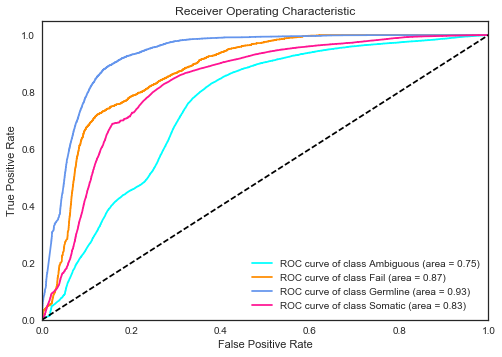

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00089957  0.0035822   0.00459466  0.00629871  0.00845529  0.00863959
  0.01109931  0.01290466  0.01475754  0.01565947]


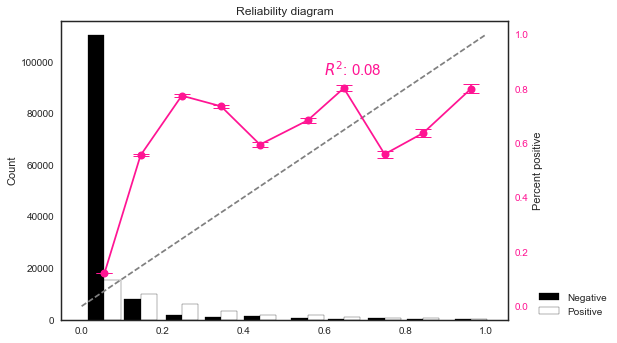

In [19]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 'deeppink')

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [18]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [19]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [20]:
training_data.groupby('binary_call').size()

binary_call
False    20498
True     21156
dtype: int64

In [21]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [22]:
X.shape

(41654, 71)

In [23]:
binary_Y.shape

(41654,)

In [24]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=700, batch_size=2000, verbose=1)

In [26]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [27]:
if not os.path.exists('../data/log_reg/binary_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/log_reg/binary_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/log_reg/binary_probs.npy')

Epoch 1/700
37488/37488 [==============================] - 1s - loss: 0.6877 - acc: 0.5446     
Epoch 2/700
37488/37488 [==============================] - 0s - loss: 0.6790 - acc: 0.5789     
Epoch 3/700
37488/37488 [==============================] - 0s - loss: 0.6708 - acc: 0.6564     
Epoch 4/700
37488/37488 [==============================] - 0s - loss: 0.6627 - acc: 0.6547     
Epoch 5/700
37488/37488 [==============================] - 0s - loss: 0.6548 - acc: 0.6494     
Epoch 6/700
37488/37488 [==============================] - 0s - loss: 0.6470 - acc: 0.6512     
Epoch 7/700
37488/37488 [==============================] - 0s - loss: 0.6394 - acc: 0.6532     
Epoch 8/700
37488/37488 [==============================] - 0s - loss: 0.6322 - acc: 0.6576     
Epoch 9/700
37488/37488 [==============================] - 0s - loss: 0.6254 - acc: 0.6624     
Epoch 10/700
37488/37488 [==============================] - 0s - loss: 0.6190 - acc: 0.6673     
Epoch 11/700
37488/37488 [=============

37488/37488 [==============================] - 0s - loss: 0.4833 - acc: 0.7926     
Epoch 86/700
37488/37488 [==============================] - 0s - loss: 0.4828 - acc: 0.7916     
Epoch 87/700
37488/37488 [==============================] - 0s - loss: 0.4822 - acc: 0.7941     
Epoch 88/700
37488/37488 [==============================] - 0s - loss: 0.4817 - acc: 0.7916     
Epoch 89/700
37488/37488 [==============================] - 0s - loss: 0.4811 - acc: 0.7956     
Epoch 90/700
37488/37488 [==============================] - 0s - loss: 0.4806 - acc: 0.7932     
Epoch 91/700
37488/37488 [==============================] - 0s - loss: 0.4800 - acc: 0.7952     
Epoch 92/700
37488/37488 [==============================] - 0s - loss: 0.4795 - acc: 0.7957     
Epoch 93/700
37488/37488 [==============================] - 0s - loss: 0.4790 - acc: 0.7958     
Epoch 94/700
37488/37488 [==============================] - 0s - loss: 0.4785 - acc: 0.7966     
Epoch 95/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.4546 - acc: 0.8181     
Epoch 169/700
37488/37488 [==============================] - 0s - loss: 0.4544 - acc: 0.8176     
Epoch 170/700
37488/37488 [==============================] - 0s - loss: 0.4542 - acc: 0.8186     
Epoch 171/700
37488/37488 [==============================] - 0s - loss: 0.4540 - acc: 0.8190     
Epoch 172/700
37488/37488 [==============================] - 0s - loss: 0.4538 - acc: 0.8184     
Epoch 173/700
37488/37488 [==============================] - 0s - loss: 0.4536 - acc: 0.8187     
Epoch 174/700
37488/37488 [==============================] - 0s - loss: 0.4534 - acc: 0.8184     
Epoch 175/700
37488/37488 [==============================] - 0s - loss: 0.4532 - acc: 0.8194     
Epoch 176/700
37488/37488 [==============================] - 0s - loss: 0.4530 - acc: 0.8194     
Epoch 177/700
37488/37488 [==============================] - 0s - loss: 0.4528 - acc: 0.8190     
Epoch 178/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4420 - acc: 0.8253     
Epoch 252/700
37488/37488 [==============================] - 0s - loss: 0.4419 - acc: 0.8246     
Epoch 253/700
37488/37488 [==============================] - 0s - loss: 0.4417 - acc: 0.8250     
Epoch 254/700
37488/37488 [==============================] - 0s - loss: 0.4416 - acc: 0.8253     
Epoch 255/700
37488/37488 [==============================] - 0s - loss: 0.4415 - acc: 0.8249     
Epoch 256/700
37488/37488 [==============================] - 0s - loss: 0.4414 - acc: 0.8252     
Epoch 257/700
37488/37488 [==============================] - 0s - loss: 0.4413 - acc: 0.8253     
Epoch 258/700
37488/37488 [==============================] - 0s - loss: 0.4412 - acc: 0.8251     
Epoch 259/700
37488/37488 [==============================] - 0s - loss: 0.4411 - acc: 0.8254     
Epoch 260/700
37488/37488 [==============================] - 0s - loss: 0.4409 - acc: 0.8255     
Epoch 261/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4336 - acc: 0.8271     
Epoch 335/700
37488/37488 [==============================] - 0s - loss: 0.4335 - acc: 0.8274     
Epoch 336/700
37488/37488 [==============================] - 0s - loss: 0.4334 - acc: 0.8273     
Epoch 337/700
37488/37488 [==============================] - 0s - loss: 0.4333 - acc: 0.8271     
Epoch 338/700
37488/37488 [==============================] - 0s - loss: 0.4332 - acc: 0.8272     
Epoch 339/700
37488/37488 [==============================] - 0s - loss: 0.4332 - acc: 0.8278     
Epoch 340/700
37488/37488 [==============================] - 0s - loss: 0.4330 - acc: 0.8279     
Epoch 341/700
37488/37488 [==============================] - 0s - loss: 0.4329 - acc: 0.8272     
Epoch 342/700
37488/37488 [==============================] - 0s - loss: 0.4329 - acc: 0.8271     
Epoch 343/700
37488/37488 [==============================] - 0s - loss: 0.4328 - acc: 0.8276     
Epoch 344/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4264 - acc: 0.8289     
Epoch 418/700
37488/37488 [==============================] - 0s - loss: 0.4263 - acc: 0.8293     
Epoch 419/700
37488/37488 [==============================] - 0s - loss: 0.4262 - acc: 0.8288     
Epoch 420/700
37488/37488 [==============================] - 0s - loss: 0.4262 - acc: 0.8286     
Epoch 421/700
37488/37488 [==============================] - 0s - loss: 0.4260 - acc: 0.8290     
Epoch 422/700
37488/37488 [==============================] - 0s - loss: 0.4260 - acc: 0.8289     
Epoch 423/700
37488/37488 [==============================] - 0s - loss: 0.4259 - acc: 0.8289     
Epoch 424/700
37488/37488 [==============================] - 0s - loss: 0.4258 - acc: 0.8293     
Epoch 425/700
37488/37488 [==============================] - 0s - loss: 0.4257 - acc: 0.8289     
Epoch 426/700
37488/37488 [==============================] - 0s - loss: 0.4256 - acc: 0.8288     
Epoch 427/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4199 - acc: 0.8297     
Epoch 501/700
37488/37488 [==============================] - 0s - loss: 0.4199 - acc: 0.8298     
Epoch 502/700
37488/37488 [==============================] - 0s - loss: 0.4198 - acc: 0.8295     
Epoch 503/700
37488/37488 [==============================] - 0s - loss: 0.4197 - acc: 0.8297     
Epoch 504/700
37488/37488 [==============================] - 0s - loss: 0.4196 - acc: 0.8298     
Epoch 505/700
37488/37488 [==============================] - 0s - loss: 0.4196 - acc: 0.8298     
Epoch 506/700
37488/37488 [==============================] - 0s - loss: 0.4195 - acc: 0.8297     
Epoch 507/700
37488/37488 [==============================] - 0s - loss: 0.4194 - acc: 0.8301     
Epoch 508/700
37488/37488 [==============================] - 0s - loss: 0.4193 - acc: 0.8300     
Epoch 509/700
37488/37488 [==============================] - 0s - loss: 0.4193 - acc: 0.8299     
Epoch 510/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4141 - acc: 0.8305     
Epoch 584/700
37488/37488 [==============================] - 0s - loss: 0.4141 - acc: 0.8305     
Epoch 585/700
37488/37488 [==============================] - 0s - loss: 0.4140 - acc: 0.8305     
Epoch 586/700
37488/37488 [==============================] - 0s - loss: 0.4139 - acc: 0.8308     
Epoch 587/700
37488/37488 [==============================] - 0s - loss: 0.4139 - acc: 0.8306     
Epoch 588/700
37488/37488 [==============================] - 0s - loss: 0.4138 - acc: 0.8308     
Epoch 589/700
37488/37488 [==============================] - 0s - loss: 0.4137 - acc: 0.8307     
Epoch 590/700
37488/37488 [==============================] - 0s - loss: 0.4137 - acc: 0.8307     
Epoch 591/700
37488/37488 [==============================] - 0s - loss: 0.4136 - acc: 0.8306     
Epoch 592/700
37488/37488 [==============================] - 0s - loss: 0.4136 - acc: 0.8310     
Epoch 593/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4090 - acc: 0.8312     
Epoch 667/700
37488/37488 [==============================] - 0s - loss: 0.4090 - acc: 0.8310     
Epoch 668/700
37488/37488 [==============================] - 0s - loss: 0.4089 - acc: 0.8312     
Epoch 669/700
37488/37488 [==============================] - 0s - loss: 0.4089 - acc: 0.8311     
Epoch 670/700
37488/37488 [==============================] - 0s - loss: 0.4088 - acc: 0.8309     
Epoch 671/700
37488/37488 [==============================] - 0s - loss: 0.4087 - acc: 0.8309     
Epoch 672/700
37488/37488 [==============================] - 0s - loss: 0.4087 - acc: 0.8311     
Epoch 673/700
37488/37488 [==============================] - 0s - loss: 0.4087 - acc: 0.8310     
Epoch 674/700
37488/37488 [==============================] - 0s - loss: 0.4087 - acc: 0.8310     
Epoch 675/700
37488/37488 [==============================] - 0s - loss: 0.4085 - acc: 0.8310     
Epoch 676/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.5148 - acc: 0.7586     
Epoch 50/700
37488/37488 [==============================] - 0s - loss: 0.5136 - acc: 0.7619     
Epoch 51/700
37488/37488 [==============================] - 0s - loss: 0.5125 - acc: 0.7611     
Epoch 52/700
37488/37488 [==============================] - 0s - loss: 0.5115 - acc: 0.7626     
Epoch 53/700
37488/37488 [==============================] - 0s - loss: 0.5103 - acc: 0.7653     
Epoch 54/700
37488/37488 [==============================] - 0s - loss: 0.5091 - acc: 0.7655     
Epoch 55/700
37488/37488 [==============================] - 0s - loss: 0.5081 - acc: 0.7650     
Epoch 56/700
37488/37488 [==============================] - 0s - loss: 0.5071 - acc: 0.7670     
Epoch 57/700
37488/37488 [==============================] - 0s - loss: 0.5061 - acc: 0.7663     
Epoch 58/700
37488/37488 [==============================] - 0s - loss: 0.5051 - acc: 0.7706     
Epoch 59/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.4644 - acc: 0.8126     
Epoch 134/700
37488/37488 [==============================] - 0s - loss: 0.4641 - acc: 0.8111     
Epoch 135/700
37488/37488 [==============================] - 0s - loss: 0.4638 - acc: 0.8114     
Epoch 136/700
37488/37488 [==============================] - 0s - loss: 0.4636 - acc: 0.8128     
Epoch 137/700
37488/37488 [==============================] - 0s - loss: 0.4633 - acc: 0.8119     
Epoch 138/700
37488/37488 [==============================] - 0s - loss: 0.4629 - acc: 0.8120     
Epoch 139/700
37488/37488 [==============================] - 0s - loss: 0.4627 - acc: 0.8131     
Epoch 140/700
37488/37488 [==============================] - 0s - loss: 0.4623 - acc: 0.8124     
Epoch 141/700
37488/37488 [==============================] - 0s - loss: 0.4620 - acc: 0.8135     
Epoch 142/700
37488/37488 [==============================] - 0s - loss: 0.4618 - acc: 0.8144     
Epoch 143/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4471 - acc: 0.8229     
Epoch 217/700
37488/37488 [==============================] - 0s - loss: 0.4470 - acc: 0.8228     
Epoch 218/700
37488/37488 [==============================] - 0s - loss: 0.4469 - acc: 0.8235     
Epoch 219/700
37488/37488 [==============================] - 0s - loss: 0.4467 - acc: 0.8233     
Epoch 220/700
37488/37488 [==============================] - 0s - loss: 0.4466 - acc: 0.8230     
Epoch 221/700
37488/37488 [==============================] - 0s - loss: 0.4465 - acc: 0.8234     
Epoch 222/700
37488/37488 [==============================] - 0s - loss: 0.4464 - acc: 0.8233     
Epoch 223/700
37488/37488 [==============================] - 0s - loss: 0.4462 - acc: 0.8239     
Epoch 224/700
37488/37488 [==============================] - 0s - loss: 0.4461 - acc: 0.8237     
Epoch 225/700
37488/37488 [==============================] - 0s - loss: 0.4459 - acc: 0.8233     
Epoch 226/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4377 - acc: 0.8268     
Epoch 300/700
37488/37488 [==============================] - 0s - loss: 0.4375 - acc: 0.8271     
Epoch 301/700
37488/37488 [==============================] - 0s - loss: 0.4373 - acc: 0.8270     
Epoch 302/700
37488/37488 [==============================] - 0s - loss: 0.4372 - acc: 0.8272     
Epoch 303/700
37488/37488 [==============================] - 0s - loss: 0.4372 - acc: 0.8270     
Epoch 304/700
37488/37488 [==============================] - 0s - loss: 0.4371 - acc: 0.8271     
Epoch 305/700
37488/37488 [==============================] - 0s - loss: 0.4370 - acc: 0.8273     
Epoch 306/700
37488/37488 [==============================] - 0s - loss: 0.4369 - acc: 0.8275     
Epoch 307/700
37488/37488 [==============================] - 0s - loss: 0.4368 - acc: 0.8272     
Epoch 308/700
37488/37488 [==============================] - 0s - loss: 0.4367 - acc: 0.8273     
Epoch 309/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4300 - acc: 0.8290     
Epoch 383/700
37488/37488 [==============================] - 0s - loss: 0.4299 - acc: 0.8290     
Epoch 384/700
37488/37488 [==============================] - 0s - loss: 0.4299 - acc: 0.8286     
Epoch 385/700
37488/37488 [==============================] - 0s - loss: 0.4298 - acc: 0.8291     
Epoch 386/700
37488/37488 [==============================] - 0s - loss: 0.4297 - acc: 0.8288     
Epoch 387/700
37488/37488 [==============================] - 0s - loss: 0.4296 - acc: 0.8294     
Epoch 388/700
37488/37488 [==============================] - 0s - loss: 0.4295 - acc: 0.8288     
Epoch 389/700
37488/37488 [==============================] - 0s - loss: 0.4294 - acc: 0.8291     
Epoch 390/700
37488/37488 [==============================] - 0s - loss: 0.4293 - acc: 0.8288     
Epoch 391/700
37488/37488 [==============================] - 0s - loss: 0.4292 - acc: 0.8291     
Epoch 392/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4232 - acc: 0.8302     
Epoch 466/700
37488/37488 [==============================] - 0s - loss: 0.4231 - acc: 0.8302     
Epoch 467/700
37488/37488 [==============================] - 0s - loss: 0.4231 - acc: 0.8303     
Epoch 468/700
37488/37488 [==============================] - 0s - loss: 0.4230 - acc: 0.8303     
Epoch 469/700
37488/37488 [==============================] - 0s - loss: 0.4229 - acc: 0.8302     
Epoch 470/700
37488/37488 [==============================] - 0s - loss: 0.4229 - acc: 0.8299     
Epoch 471/700
37488/37488 [==============================] - 0s - loss: 0.4228 - acc: 0.8299     
Epoch 472/700
37488/37488 [==============================] - 0s - loss: 0.4228 - acc: 0.8301     
Epoch 473/700
37488/37488 [==============================] - 0s - loss: 0.4226 - acc: 0.8303     
Epoch 474/700
37488/37488 [==============================] - 0s - loss: 0.4226 - acc: 0.8299     
Epoch 475/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4173 - acc: 0.8305     
Epoch 549/700
37488/37488 [==============================] - 0s - loss: 0.4172 - acc: 0.8307     
Epoch 550/700
37488/37488 [==============================] - 0s - loss: 0.4171 - acc: 0.8305     
Epoch 551/700
37488/37488 [==============================] - 0s - loss: 0.4171 - acc: 0.8307     
Epoch 552/700
37488/37488 [==============================] - 0s - loss: 0.4170 - acc: 0.8307     
Epoch 553/700
37488/37488 [==============================] - 0s - loss: 0.4169 - acc: 0.8303     
Epoch 554/700
37488/37488 [==============================] - 0s - loss: 0.4169 - acc: 0.8311     
Epoch 555/700
37488/37488 [==============================] - 0s - loss: 0.4168 - acc: 0.8310     
Epoch 556/700
37488/37488 [==============================] - 0s - loss: 0.4167 - acc: 0.8307     
Epoch 557/700
37488/37488 [==============================] - 0s - loss: 0.4166 - acc: 0.8308     
Epoch 558/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4117 - acc: 0.8313     
Epoch 632/700
37488/37488 [==============================] - 0s - loss: 0.4117 - acc: 0.8314     
Epoch 633/700
37488/37488 [==============================] - 0s - loss: 0.4116 - acc: 0.8315     
Epoch 634/700
37488/37488 [==============================] - 0s - loss: 0.4116 - acc: 0.8317     
Epoch 635/700
37488/37488 [==============================] - 0s - loss: 0.4115 - acc: 0.8315     
Epoch 636/700
37488/37488 [==============================] - 0s - loss: 0.4114 - acc: 0.8315     
Epoch 637/700
37488/37488 [==============================] - 0s - loss: 0.4114 - acc: 0.8317     
Epoch 638/700
37488/37488 [==============================] - 0s - loss: 0.4113 - acc: 0.8313     
Epoch 639/700
37488/37488 [==============================] - 0s - loss: 0.4113 - acc: 0.8317     
Epoch 640/700
37488/37488 [==============================] - 0s - loss: 0.4112 - acc: 0.8314     
Epoch 641/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.5937 - acc: 0.6984     
Epoch 15/700
37488/37488 [==============================] - 0s - loss: 0.5891 - acc: 0.7029     
Epoch 16/700
37488/37488 [==============================] - 0s - loss: 0.5849 - acc: 0.7076     
Epoch 17/700
37488/37488 [==============================] - 0s - loss: 0.5808 - acc: 0.7108     
Epoch 18/700
37488/37488 [==============================] - 0s - loss: 0.5770 - acc: 0.7141     
Epoch 19/700
37488/37488 [==============================] - 0s - loss: 0.5734 - acc: 0.7167     
Epoch 20/700
37488/37488 [==============================] - 0s - loss: 0.5699 - acc: 0.7191     
Epoch 21/700
37488/37488 [==============================] - 0s - loss: 0.5667 - acc: 0.7215     
Epoch 22/700
37488/37488 [==============================] - 0s - loss: 0.5637 - acc: 0.7217     
Epoch 23/700
37488/37488 [==============================] - 0s - loss: 0.5606 - acc: 0.7235     
Epoch 24/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.4757 - acc: 0.8003     
Epoch 99/700
37488/37488 [==============================] - 0s - loss: 0.4752 - acc: 0.7986     
Epoch 100/700
37488/37488 [==============================] - 0s - loss: 0.4747 - acc: 0.7999     
Epoch 101/700
37488/37488 [==============================] - 0s - loss: 0.4742 - acc: 0.8006     
Epoch 102/700
37488/37488 [==============================] - 0s - loss: 0.4738 - acc: 0.8014     
Epoch 103/700
37488/37488 [==============================] - 0s - loss: 0.4733 - acc: 0.8021     
Epoch 104/700
37488/37488 [==============================] - 0s - loss: 0.4729 - acc: 0.8014     
Epoch 105/700
37488/37488 [==============================] - 0s - loss: 0.4724 - acc: 0.8038     
Epoch 106/700
37488/37488 [==============================] - 0s - loss: 0.4720 - acc: 0.8012     
Epoch 107/700
37488/37488 [==============================] - 0s - loss: 0.4716 - acc: 0.8032     
Epoch 108/700
37488/37488 [========

37488/37488 [==============================] - 0s - loss: 0.4505 - acc: 0.8220     
Epoch 182/700
37488/37488 [==============================] - 0s - loss: 0.4503 - acc: 0.8222     
Epoch 183/700
37488/37488 [==============================] - 0s - loss: 0.4501 - acc: 0.8224     
Epoch 184/700
37488/37488 [==============================] - 0s - loss: 0.4499 - acc: 0.8219     
Epoch 185/700
37488/37488 [==============================] - 0s - loss: 0.4498 - acc: 0.8230     
Epoch 186/700
37488/37488 [==============================] - 0s - loss: 0.4496 - acc: 0.8223     
Epoch 187/700
37488/37488 [==============================] - 0s - loss: 0.4494 - acc: 0.8229     
Epoch 188/700
37488/37488 [==============================] - 0s - loss: 0.4493 - acc: 0.8230     
Epoch 189/700
37488/37488 [==============================] - 0s - loss: 0.4491 - acc: 0.8224     
Epoch 190/700
37488/37488 [==============================] - 0s - loss: 0.4489 - acc: 0.8231     
Epoch 191/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4388 - acc: 0.8271     
Epoch 265/700
37488/37488 [==============================] - 0s - loss: 0.4386 - acc: 0.8271     
Epoch 266/700
37488/37488 [==============================] - 0s - loss: 0.4385 - acc: 0.8273     
Epoch 267/700
37488/37488 [==============================] - 0s - loss: 0.4384 - acc: 0.8273     
Epoch 268/700
37488/37488 [==============================] - 0s - loss: 0.4383 - acc: 0.8275     
Epoch 269/700
37488/37488 [==============================] - 0s - loss: 0.4382 - acc: 0.8271     
Epoch 270/700
37488/37488 [==============================] - 0s - loss: 0.4382 - acc: 0.8272     
Epoch 271/700
37488/37488 [==============================] - 0s - loss: 0.4380 - acc: 0.8281     
Epoch 272/700
37488/37488 [==============================] - 0s - loss: 0.4379 - acc: 0.8275     
Epoch 273/700
37488/37488 [==============================] - 0s - loss: 0.4378 - acc: 0.8275     
Epoch 274/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4307 - acc: 0.8297     
Epoch 348/700
37488/37488 [==============================] - 0s - loss: 0.4306 - acc: 0.8296     
Epoch 349/700
37488/37488 [==============================] - 0s - loss: 0.4306 - acc: 0.8297     
Epoch 350/700
37488/37488 [==============================] - 0s - loss: 0.4305 - acc: 0.8292     
Epoch 351/700
37488/37488 [==============================] - 0s - loss: 0.4303 - acc: 0.8302     
Epoch 352/700
37488/37488 [==============================] - 0s - loss: 0.4303 - acc: 0.8297     
Epoch 353/700
37488/37488 [==============================] - 0s - loss: 0.4302 - acc: 0.8298     
Epoch 354/700
37488/37488 [==============================] - 0s - loss: 0.4301 - acc: 0.8298     
Epoch 355/700
37488/37488 [==============================] - 0s - loss: 0.4300 - acc: 0.8303     
Epoch 356/700
37488/37488 [==============================] - 0s - loss: 0.4299 - acc: 0.8300     
Epoch 357/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4234 - acc: 0.8312     
Epoch 431/700
37488/37488 [==============================] - 0s - loss: 0.4234 - acc: 0.8305     
Epoch 432/700
37488/37488 [==============================] - 0s - loss: 0.4232 - acc: 0.8315     
Epoch 433/700
37488/37488 [==============================] - 0s - loss: 0.4232 - acc: 0.8311     
Epoch 434/700
37488/37488 [==============================] - 0s - loss: 0.4231 - acc: 0.8312     
Epoch 435/700
37488/37488 [==============================] - 0s - loss: 0.4230 - acc: 0.8312     
Epoch 436/700
37488/37488 [==============================] - 0s - loss: 0.4229 - acc: 0.8313     
Epoch 437/700
37488/37488 [==============================] - 0s - loss: 0.4229 - acc: 0.8312     
Epoch 438/700
37488/37488 [==============================] - 0s - loss: 0.4227 - acc: 0.8312     
Epoch 439/700
37488/37488 [==============================] - 0s - loss: 0.4226 - acc: 0.8314     
Epoch 440/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4169 - acc: 0.8320     
Epoch 514/700
37488/37488 [==============================] - 0s - loss: 0.4169 - acc: 0.8320     
Epoch 515/700
37488/37488 [==============================] - 0s - loss: 0.4169 - acc: 0.8319     
Epoch 516/700
37488/37488 [==============================] - 0s - loss: 0.4167 - acc: 0.8321     
Epoch 517/700
37488/37488 [==============================] - 0s - loss: 0.4166 - acc: 0.8320     
Epoch 518/700
37488/37488 [==============================] - 0s - loss: 0.4166 - acc: 0.8323     
Epoch 519/700
37488/37488 [==============================] - 0s - loss: 0.4165 - acc: 0.8318     
Epoch 520/700
37488/37488 [==============================] - 0s - loss: 0.4164 - acc: 0.8321     
Epoch 521/700
37488/37488 [==============================] - 0s - loss: 0.4163 - acc: 0.8320     
Epoch 522/700
37488/37488 [==============================] - 0s - loss: 0.4162 - acc: 0.8321     
Epoch 523/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4112 - acc: 0.8331     
Epoch 597/700
37488/37488 [==============================] - 0s - loss: 0.4111 - acc: 0.8331     
Epoch 598/700
37488/37488 [==============================] - 0s - loss: 0.4111 - acc: 0.8330     
Epoch 599/700
37488/37488 [==============================] - 0s - loss: 0.4111 - acc: 0.8327     
Epoch 600/700
37488/37488 [==============================] - 0s - loss: 0.4109 - acc: 0.8331     
Epoch 601/700
37488/37488 [==============================] - 0s - loss: 0.4108 - acc: 0.8331     
Epoch 602/700
37488/37488 [==============================] - 0s - loss: 0.4108 - acc: 0.8327     
Epoch 603/700
37488/37488 [==============================] - 0s - loss: 0.4107 - acc: 0.8331     
Epoch 604/700
37488/37488 [==============================] - 0s - loss: 0.4107 - acc: 0.8331     
Epoch 605/700
37488/37488 [==============================] - 0s - loss: 0.4106 - acc: 0.8331     
Epoch 606/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4061 - acc: 0.8332     
Epoch 680/700
37488/37488 [==============================] - 0s - loss: 0.4061 - acc: 0.8334     
Epoch 681/700
37488/37488 [==============================] - 0s - loss: 0.4060 - acc: 0.8334     
Epoch 682/700
37488/37488 [==============================] - 0s - loss: 0.4060 - acc: 0.8335     
Epoch 683/700
37488/37488 [==============================] - 0s - loss: 0.4059 - acc: 0.8332     
Epoch 684/700
37488/37488 [==============================] - 0s - loss: 0.4059 - acc: 0.8332     
Epoch 685/700
37488/37488 [==============================] - 0s - loss: 0.4058 - acc: 0.8335     
Epoch 686/700
37488/37488 [==============================] - 0s - loss: 0.4057 - acc: 0.8332     
Epoch 687/700
37488/37488 [==============================] - 0s - loss: 0.4057 - acc: 0.8334     
Epoch 688/700
37488/37488 [==============================] - 0s - loss: 0.4057 - acc: 0.8333     
Epoch 689/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.5034 - acc: 0.7677     
Epoch 63/700
37488/37488 [==============================] - 0s - loss: 0.5025 - acc: 0.7685     
Epoch 64/700
37488/37488 [==============================] - 0s - loss: 0.5016 - acc: 0.7678     
Epoch 65/700
37488/37488 [==============================] - 0s - loss: 0.5008 - acc: 0.7725     
Epoch 66/700
37488/37488 [==============================] - 0s - loss: 0.4999 - acc: 0.7712     
Epoch 67/700
37488/37488 [==============================] - 0s - loss: 0.4990 - acc: 0.7749     
Epoch 68/700
37488/37488 [==============================] - 0s - loss: 0.4982 - acc: 0.7720     
Epoch 69/700
37488/37488 [==============================] - 0s - loss: 0.4973 - acc: 0.7701     
Epoch 70/700
37488/37488 [==============================] - 0s - loss: 0.4965 - acc: 0.7763     
Epoch 71/700
37488/37488 [==============================] - 0s - loss: 0.4957 - acc: 0.7730     
Epoch 72/700
37488/37488 [=================

37488/37488 [==============================] - 0s - loss: 0.4609 - acc: 0.8127     
Epoch 147/700
37488/37488 [==============================] - 0s - loss: 0.4606 - acc: 0.8134     
Epoch 148/700
37488/37488 [==============================] - 0s - loss: 0.4603 - acc: 0.8153     
Epoch 149/700
37488/37488 [==============================] - 0s - loss: 0.4601 - acc: 0.8130     
Epoch 150/700
37488/37488 [==============================] - 0s - loss: 0.4598 - acc: 0.8156     
Epoch 151/700
37488/37488 [==============================] - 0s - loss: 0.4596 - acc: 0.8133     
Epoch 152/700
37488/37488 [==============================] - 0s - loss: 0.4593 - acc: 0.8149     
Epoch 153/700
37488/37488 [==============================] - 0s - loss: 0.4590 - acc: 0.8154     
Epoch 154/700
37488/37488 [==============================] - 0s - loss: 0.4588 - acc: 0.8157     
Epoch 155/700
37488/37488 [==============================] - 0s - loss: 0.4585 - acc: 0.8148     
Epoch 156/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4450 - acc: 0.8235     
Epoch 230/700
37488/37488 [==============================] - 0s - loss: 0.4448 - acc: 0.8237     
Epoch 231/700
37488/37488 [==============================] - 0s - loss: 0.4446 - acc: 0.8236     
Epoch 232/700
37488/37488 [==============================] - 0s - loss: 0.4445 - acc: 0.8244     
Epoch 233/700
37488/37488 [==============================] - 0s - loss: 0.4443 - acc: 0.8242     
Epoch 234/700
37488/37488 [==============================] - 0s - loss: 0.4442 - acc: 0.8239     
Epoch 235/700
37488/37488 [==============================] - 0s - loss: 0.4441 - acc: 0.8235     
Epoch 236/700
37488/37488 [==============================] - 0s - loss: 0.4440 - acc: 0.8249     
Epoch 237/700
37488/37488 [==============================] - 0s - loss: 0.4438 - acc: 0.8244     
Epoch 238/700
37488/37488 [==============================] - 0s - loss: 0.4437 - acc: 0.8248     
Epoch 239/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4355 - acc: 0.8275     
Epoch 313/700
37488/37488 [==============================] - 0s - loss: 0.4354 - acc: 0.8276     
Epoch 314/700
37488/37488 [==============================] - 0s - loss: 0.4353 - acc: 0.8271     
Epoch 315/700
37488/37488 [==============================] - 0s - loss: 0.4352 - acc: 0.8275     
Epoch 316/700
37488/37488 [==============================] - 0s - loss: 0.4352 - acc: 0.8280     
Epoch 317/700
37488/37488 [==============================] - 0s - loss: 0.4350 - acc: 0.8277     
Epoch 318/700
37488/37488 [==============================] - 0s - loss: 0.4348 - acc: 0.8278     
Epoch 319/700
37488/37488 [==============================] - 0s - loss: 0.4348 - acc: 0.8276     
Epoch 320/700
37488/37488 [==============================] - 0s - loss: 0.4347 - acc: 0.8274     
Epoch 321/700
37488/37488 [==============================] - 0s - loss: 0.4347 - acc: 0.8282     
Epoch 322/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4281 - acc: 0.8294     
Epoch 396/700
37488/37488 [==============================] - 0s - loss: 0.4279 - acc: 0.8289     
Epoch 397/700
37488/37488 [==============================] - 0s - loss: 0.4279 - acc: 0.8290     
Epoch 398/700
37488/37488 [==============================] - 0s - loss: 0.4278 - acc: 0.8289     
Epoch 399/700
37488/37488 [==============================] - 0s - loss: 0.4277 - acc: 0.8286     
Epoch 400/700
37488/37488 [==============================] - 0s - loss: 0.4277 - acc: 0.8290     
Epoch 401/700
37488/37488 [==============================] - 0s - loss: 0.4275 - acc: 0.8292     
Epoch 402/700
37488/37488 [==============================] - 0s - loss: 0.4275 - acc: 0.8291     
Epoch 403/700
37488/37488 [==============================] - 0s - loss: 0.4274 - acc: 0.8286     
Epoch 404/700
37488/37488 [==============================] - 0s - loss: 0.4273 - acc: 0.8291     
Epoch 405/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4214 - acc: 0.8301     
Epoch 479/700
37488/37488 [==============================] - 0s - loss: 0.4214 - acc: 0.8299     
Epoch 480/700
37488/37488 [==============================] - 0s - loss: 0.4213 - acc: 0.8298     
Epoch 481/700
37488/37488 [==============================] - 0s - loss: 0.4212 - acc: 0.8301     
Epoch 482/700
37488/37488 [==============================] - 0s - loss: 0.4212 - acc: 0.8296     
Epoch 483/700
37488/37488 [==============================] - 0s - loss: 0.4211 - acc: 0.8301     
Epoch 484/700
37488/37488 [==============================] - 0s - loss: 0.4210 - acc: 0.8304     
Epoch 485/700
37488/37488 [==============================] - 0s - loss: 0.4209 - acc: 0.8303     
Epoch 486/700
37488/37488 [==============================] - 0s - loss: 0.4209 - acc: 0.8301     
Epoch 487/700
37488/37488 [==============================] - 0s - loss: 0.4208 - acc: 0.8301     
Epoch 488/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4154 - acc: 0.8307     
Epoch 562/700
37488/37488 [==============================] - 0s - loss: 0.4154 - acc: 0.8308     
Epoch 563/700
37488/37488 [==============================] - 0s - loss: 0.4153 - acc: 0.8308     
Epoch 564/700
37488/37488 [==============================] - 0s - loss: 0.4153 - acc: 0.8312     
Epoch 565/700
37488/37488 [==============================] - 0s - loss: 0.4151 - acc: 0.8309     
Epoch 566/700
37488/37488 [==============================] - 0s - loss: 0.4151 - acc: 0.8311     
Epoch 567/700
37488/37488 [==============================] - 0s - loss: 0.4150 - acc: 0.8310     
Epoch 568/700
37488/37488 [==============================] - 0s - loss: 0.4149 - acc: 0.8309     
Epoch 569/700
37488/37488 [==============================] - 0s - loss: 0.4149 - acc: 0.8315     
Epoch 570/700
37488/37488 [==============================] - 0s - loss: 0.4148 - acc: 0.8307     
Epoch 571/700
37488/37488 [=======

37488/37488 [==============================] - 0s - loss: 0.4100 - acc: 0.8311     
Epoch 645/700
37488/37488 [==============================] - 0s - loss: 0.4099 - acc: 0.8314     
Epoch 646/700
37488/37488 [==============================] - 0s - loss: 0.4099 - acc: 0.8314     
Epoch 647/700
37488/37488 [==============================] - 0s - loss: 0.4098 - acc: 0.8312     
Epoch 648/700
37488/37488 [==============================] - 0s - loss: 0.4097 - acc: 0.8312     
Epoch 649/700
37488/37488 [==============================] - 0s - loss: 0.4097 - acc: 0.8314     
Epoch 650/700
37488/37488 [==============================] - 0s - loss: 0.4096 - acc: 0.8317     
Epoch 651/700
37488/37488 [==============================] - 0s - loss: 0.4096 - acc: 0.8309     
Epoch 652/700
37488/37488 [==============================] - 0s - loss: 0.4095 - acc: 0.8312     
Epoch 653/700
37488/37488 [==============================] - 0s - loss: 0.4094 - acc: 0.8311     
Epoch 654/700
37488/37488 [=======

37489/37489 [==============================] - 0s - loss: 0.5486 - acc: 0.7290     
Epoch 28/700
37489/37489 [==============================] - 0s - loss: 0.5462 - acc: 0.7303     
Epoch 29/700
37489/37489 [==============================] - 0s - loss: 0.5440 - acc: 0.7313     
Epoch 30/700
37489/37489 [==============================] - 0s - loss: 0.5418 - acc: 0.7323     
Epoch 31/700
37489/37489 [==============================] - 0s - loss: 0.5397 - acc: 0.7325     
Epoch 32/700
37489/37489 [==============================] - 0s - loss: 0.5377 - acc: 0.7335     
Epoch 33/700
37489/37489 [==============================] - 0s - loss: 0.5357 - acc: 0.7335     
Epoch 34/700
37489/37489 [==============================] - 0s - loss: 0.5339 - acc: 0.7362     
Epoch 35/700
37489/37489 [==============================] - 0s - loss: 0.5322 - acc: 0.7361     
Epoch 36/700
37489/37489 [==============================] - 0s - loss: 0.5304 - acc: 0.7371     
Epoch 37/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4705 - acc: 0.8035     
Epoch 112/700
37489/37489 [==============================] - 0s - loss: 0.4702 - acc: 0.8044     
Epoch 113/700
37489/37489 [==============================] - 0s - loss: 0.4698 - acc: 0.8056     
Epoch 114/700
37489/37489 [==============================] - 0s - loss: 0.4695 - acc: 0.8065     
Epoch 115/700
37489/37489 [==============================] - 0s - loss: 0.4690 - acc: 0.8049     
Epoch 116/700
37489/37489 [==============================] - 0s - loss: 0.4687 - acc: 0.8068     
Epoch 117/700
37489/37489 [==============================] - 0s - loss: 0.4683 - acc: 0.8077     
Epoch 118/700
37489/37489 [==============================] - 0s - loss: 0.4680 - acc: 0.8059     
Epoch 119/700
37489/37489 [==============================] - 0s - loss: 0.4676 - acc: 0.8062     
Epoch 120/700
37489/37489 [==============================] - 0s - loss: 0.4672 - acc: 0.8094     
Epoch 121/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4493 - acc: 0.8225     
Epoch 195/700
37489/37489 [==============================] - 0s - loss: 0.4492 - acc: 0.8233     
Epoch 196/700
37489/37489 [==============================] - 0s - loss: 0.4490 - acc: 0.8234     
Epoch 197/700
37489/37489 [==============================] - 0s - loss: 0.4488 - acc: 0.8234     
Epoch 198/700
37489/37489 [==============================] - 0s - loss: 0.4487 - acc: 0.8230     
Epoch 199/700
37489/37489 [==============================] - 0s - loss: 0.4485 - acc: 0.8231     
Epoch 200/700
37489/37489 [==============================] - 0s - loss: 0.4483 - acc: 0.8234     
Epoch 201/700
37489/37489 [==============================] - 0s - loss: 0.4481 - acc: 0.8232     
Epoch 202/700
37489/37489 [==============================] - 0s - loss: 0.4480 - acc: 0.8240     
Epoch 203/700
37489/37489 [==============================] - 0s - loss: 0.4480 - acc: 0.8236     
Epoch 204/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4385 - acc: 0.8270     
Epoch 278/700
37489/37489 [==============================] - 0s - loss: 0.4384 - acc: 0.8266     
Epoch 279/700
37489/37489 [==============================] - 0s - loss: 0.4383 - acc: 0.8274     
Epoch 280/700
37489/37489 [==============================] - 0s - loss: 0.4383 - acc: 0.8266     
Epoch 281/700
37489/37489 [==============================] - 0s - loss: 0.4382 - acc: 0.8269     
Epoch 282/700
37489/37489 [==============================] - 0s - loss: 0.4379 - acc: 0.8268     
Epoch 283/700
37489/37489 [==============================] - 0s - loss: 0.4378 - acc: 0.8270     
Epoch 284/700
37489/37489 [==============================] - 0s - loss: 0.4377 - acc: 0.8273     
Epoch 285/700
37489/37489 [==============================] - 0s - loss: 0.4377 - acc: 0.8267     
Epoch 286/700
37489/37489 [==============================] - 0s - loss: 0.4375 - acc: 0.8272     
Epoch 287/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4304 - acc: 0.8290     
Epoch 361/700
37489/37489 [==============================] - 0s - loss: 0.4303 - acc: 0.8289     
Epoch 362/700
37489/37489 [==============================] - 0s - loss: 0.4302 - acc: 0.8290     
Epoch 363/700
37489/37489 [==============================] - 0s - loss: 0.4301 - acc: 0.8289     
Epoch 364/700
37489/37489 [==============================] - 0s - loss: 0.4300 - acc: 0.8290     
Epoch 365/700
37489/37489 [==============================] - 0s - loss: 0.4299 - acc: 0.8289     
Epoch 366/700
37489/37489 [==============================] - 0s - loss: 0.4298 - acc: 0.8291     
Epoch 367/700
37489/37489 [==============================] - 0s - loss: 0.4297 - acc: 0.8290     
Epoch 368/700
37489/37489 [==============================] - 0s - loss: 0.4297 - acc: 0.8289     
Epoch 369/700
37489/37489 [==============================] - 0s - loss: 0.4295 - acc: 0.8292     
Epoch 370/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4232 - acc: 0.8305     
Epoch 444/700
37489/37489 [==============================] - 0s - loss: 0.4231 - acc: 0.8301     
Epoch 445/700
37489/37489 [==============================] - 0s - loss: 0.4230 - acc: 0.8301     
Epoch 446/700
37489/37489 [==============================] - 0s - loss: 0.4230 - acc: 0.8304     
Epoch 447/700
37489/37489 [==============================] - 0s - loss: 0.4228 - acc: 0.8301     
Epoch 448/700
37489/37489 [==============================] - 0s - loss: 0.4227 - acc: 0.8302     
Epoch 449/700
37489/37489 [==============================] - 0s - loss: 0.4227 - acc: 0.8303     
Epoch 450/700
37489/37489 [==============================] - 0s - loss: 0.4226 - acc: 0.8301     
Epoch 451/700
37489/37489 [==============================] - 0s - loss: 0.4225 - acc: 0.8301     
Epoch 452/700
37489/37489 [==============================] - 0s - loss: 0.4225 - acc: 0.8306     
Epoch 453/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4169 - acc: 0.8308     
Epoch 527/700
37489/37489 [==============================] - 0s - loss: 0.4168 - acc: 0.8309     
Epoch 528/700
37489/37489 [==============================] - 0s - loss: 0.4167 - acc: 0.8311     
Epoch 529/700
37489/37489 [==============================] - 0s - loss: 0.4166 - acc: 0.8309     
Epoch 530/700
37489/37489 [==============================] - 0s - loss: 0.4166 - acc: 0.8312     
Epoch 531/700
37489/37489 [==============================] - 0s - loss: 0.4165 - acc: 0.8310     
Epoch 532/700
37489/37489 [==============================] - 0s - loss: 0.4164 - acc: 0.8312     
Epoch 533/700
37489/37489 [==============================] - 0s - loss: 0.4163 - acc: 0.8311     
Epoch 534/700
37489/37489 [==============================] - 0s - loss: 0.4163 - acc: 0.8309     
Epoch 535/700
37489/37489 [==============================] - 0s - loss: 0.4162 - acc: 0.8314     
Epoch 536/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4112 - acc: 0.8325     
Epoch 610/700
37489/37489 [==============================] - 0s - loss: 0.4112 - acc: 0.8321     
Epoch 611/700
37489/37489 [==============================] - 0s - loss: 0.4111 - acc: 0.8321     
Epoch 612/700
37489/37489 [==============================] - 0s - loss: 0.4110 - acc: 0.8322     
Epoch 613/700
37489/37489 [==============================] - 0s - loss: 0.4110 - acc: 0.8324     
Epoch 614/700
37489/37489 [==============================] - 0s - loss: 0.4110 - acc: 0.8322     
Epoch 615/700
37489/37489 [==============================] - 0s - loss: 0.4108 - acc: 0.8325     
Epoch 616/700
37489/37489 [==============================] - 0s - loss: 0.4108 - acc: 0.8323     
Epoch 617/700
37489/37489 [==============================] - 0s - loss: 0.4107 - acc: 0.8326     
Epoch 618/700
37489/37489 [==============================] - 0s - loss: 0.4106 - acc: 0.8322     
Epoch 619/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4063 - acc: 0.8326     
Epoch 692/700
37489/37489 [==============================] - 0s - loss: 0.4063 - acc: 0.8327     
Epoch 693/700
37489/37489 [==============================] - 0s - loss: 0.4063 - acc: 0.8328     
Epoch 694/700
37489/37489 [==============================] - 0s - loss: 0.4062 - acc: 0.8325     
Epoch 695/700
37489/37489 [==============================] - 0s - loss: 0.4061 - acc: 0.8328     
Epoch 696/700
37489/37489 [==============================] - 0s - loss: 0.4061 - acc: 0.8329     
Epoch 697/700
37489/37489 [==============================] - 0s - loss: 0.4060 - acc: 0.8329     
Epoch 698/700
37489/37489 [==============================] - 0s - loss: 0.4060 - acc: 0.8329     
Epoch 699/700
37489/37489 [==============================] - 0s - loss: 0.4062 - acc: 0.8333     
Epoch 700/700
37489/37489 [==============================] - 0s - loss: 0.6898 - acc: 0.5135     
Epoch 2/700
37489/37489 [=========

37489/37489 [==============================] - 0s - loss: 0.4900 - acc: 0.7777     
Epoch 75/700
37489/37489 [==============================] - 0s - loss: 0.4894 - acc: 0.7829     
Epoch 76/700
37489/37489 [==============================] - 0s - loss: 0.4888 - acc: 0.7816     
Epoch 77/700
37489/37489 [==============================] - 0s - loss: 0.4880 - acc: 0.7823     
Epoch 78/700
37489/37489 [==============================] - 0s - loss: 0.4874 - acc: 0.7832     
Epoch 79/700
37489/37489 [==============================] - 0s - loss: 0.4867 - acc: 0.7834     
Epoch 80/700
37489/37489 [==============================] - 0s - loss: 0.4860 - acc: 0.7847     
Epoch 81/700
37489/37489 [==============================] - 0s - loss: 0.4854 - acc: 0.7878     
Epoch 82/700
37489/37489 [==============================] - 0s - loss: 0.4848 - acc: 0.7857     
Epoch 83/700
37489/37489 [==============================] - 0s - loss: 0.4842 - acc: 0.7872     
Epoch 84/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4565 - acc: 0.8169     
Epoch 159/700
37489/37489 [==============================] - 0s - loss: 0.4562 - acc: 0.8161     
Epoch 160/700
37489/37489 [==============================] - 0s - loss: 0.4560 - acc: 0.8171     
Epoch 161/700
37489/37489 [==============================] - 0s - loss: 0.4558 - acc: 0.8167     
Epoch 162/700
37489/37489 [==============================] - 0s - loss: 0.4556 - acc: 0.8172     
Epoch 163/700
37489/37489 [==============================] - 0s - loss: 0.4554 - acc: 0.8182     
Epoch 164/700
37489/37489 [==============================] - 0s - loss: 0.4552 - acc: 0.8174     
Epoch 165/700
37489/37489 [==============================] - 0s - loss: 0.4549 - acc: 0.8176     
Epoch 166/700
37489/37489 [==============================] - 0s - loss: 0.4547 - acc: 0.8182     
Epoch 167/700
37489/37489 [==============================] - 0s - loss: 0.4545 - acc: 0.8175     
Epoch 168/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4429 - acc: 0.8242     
Epoch 242/700
37489/37489 [==============================] - 0s - loss: 0.4429 - acc: 0.8236     
Epoch 243/700
37489/37489 [==============================] - 0s - loss: 0.4426 - acc: 0.8242     
Epoch 244/700
37489/37489 [==============================] - 0s - loss: 0.4425 - acc: 0.8246     
Epoch 245/700
37489/37489 [==============================] - 0s - loss: 0.4425 - acc: 0.8243     
Epoch 246/700
37489/37489 [==============================] - 0s - loss: 0.4423 - acc: 0.8247     
Epoch 247/700
37489/37489 [==============================] - 0s - loss: 0.4422 - acc: 0.8247     
Epoch 248/700
37489/37489 [==============================] - 0s - loss: 0.4421 - acc: 0.8249     
Epoch 249/700
37489/37489 [==============================] - 0s - loss: 0.4421 - acc: 0.8243     
Epoch 250/700
37489/37489 [==============================] - 0s - loss: 0.4418 - acc: 0.8247     
Epoch 251/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4344 - acc: 0.8263     
Epoch 325/700
37489/37489 [==============================] - 0s - loss: 0.4344 - acc: 0.8267     
Epoch 326/700
37489/37489 [==============================] - 0s - loss: 0.4343 - acc: 0.8270     
Epoch 327/700
37489/37489 [==============================] - 0s - loss: 0.4343 - acc: 0.8273     
Epoch 328/700
37489/37489 [==============================] - 0s - loss: 0.4341 - acc: 0.8271     
Epoch 329/700
37489/37489 [==============================] - 0s - loss: 0.4340 - acc: 0.8268     
Epoch 330/700
37489/37489 [==============================] - 0s - loss: 0.4339 - acc: 0.8270     
Epoch 331/700
37489/37489 [==============================] - 0s - loss: 0.4339 - acc: 0.8269     
Epoch 332/700
37489/37489 [==============================] - 0s - loss: 0.4337 - acc: 0.8269     
Epoch 333/700
37489/37489 [==============================] - 0s - loss: 0.4337 - acc: 0.8267     
Epoch 334/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4276 - acc: 0.8284     
Epoch 408/700
37489/37489 [==============================] - 0s - loss: 0.4275 - acc: 0.8284     
Epoch 409/700
37489/37489 [==============================] - 0s - loss: 0.4275 - acc: 0.8282     
Epoch 410/700
37489/37489 [==============================] - 0s - loss: 0.4274 - acc: 0.8284     
Epoch 411/700
37489/37489 [==============================] - 0s - loss: 0.4273 - acc: 0.8284     
Epoch 412/700
37489/37489 [==============================] - 0s - loss: 0.4272 - acc: 0.8282     
Epoch 413/700
37489/37489 [==============================] - 0s - loss: 0.4271 - acc: 0.8284     
Epoch 414/700
37489/37489 [==============================] - 0s - loss: 0.4271 - acc: 0.8285     
Epoch 415/700
37489/37489 [==============================] - 0s - loss: 0.4270 - acc: 0.8289     
Epoch 416/700
37489/37489 [==============================] - 0s - loss: 0.4269 - acc: 0.8284     
Epoch 417/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4212 - acc: 0.8298     
Epoch 491/700
37489/37489 [==============================] - 0s - loss: 0.4211 - acc: 0.8298     
Epoch 492/700
37489/37489 [==============================] - 0s - loss: 0.4210 - acc: 0.8299     
Epoch 493/700
37489/37489 [==============================] - 0s - loss: 0.4209 - acc: 0.8297     
Epoch 494/700
37489/37489 [==============================] - 0s - loss: 0.4208 - acc: 0.8298     
Epoch 495/700
37489/37489 [==============================] - 0s - loss: 0.4209 - acc: 0.8301     
Epoch 496/700
37489/37489 [==============================] - 0s - loss: 0.4207 - acc: 0.8298     
Epoch 497/700
37489/37489 [==============================] - 0s - loss: 0.4206 - acc: 0.8298     
Epoch 498/700
37489/37489 [==============================] - 0s - loss: 0.4206 - acc: 0.8300     
Epoch 499/700
37489/37489 [==============================] - 0s - loss: 0.4205 - acc: 0.8299     
Epoch 500/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4154 - acc: 0.8309     
Epoch 574/700
37489/37489 [==============================] - 0s - loss: 0.4152 - acc: 0.8301     
Epoch 575/700
37489/37489 [==============================] - 0s - loss: 0.4152 - acc: 0.8303     
Epoch 576/700
37489/37489 [==============================] - 0s - loss: 0.4151 - acc: 0.8306     
Epoch 577/700
37489/37489 [==============================] - 0s - loss: 0.4150 - acc: 0.8306     
Epoch 578/700
37489/37489 [==============================] - 0s - loss: 0.4150 - acc: 0.8302     
Epoch 579/700
37489/37489 [==============================] - 0s - loss: 0.4149 - acc: 0.8308     
Epoch 580/700
37489/37489 [==============================] - 0s - loss: 0.4148 - acc: 0.8310     
Epoch 581/700
37489/37489 [==============================] - 0s - loss: 0.4148 - acc: 0.8306     
Epoch 582/700
37489/37489 [==============================] - 0s - loss: 0.4147 - acc: 0.8306     
Epoch 583/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4100 - acc: 0.8311     
Epoch 657/700
37489/37489 [==============================] - 0s - loss: 0.4099 - acc: 0.8311     
Epoch 658/700
37489/37489 [==============================] - 0s - loss: 0.4099 - acc: 0.8313     
Epoch 659/700
37489/37489 [==============================] - 0s - loss: 0.4098 - acc: 0.8313     
Epoch 660/700
37489/37489 [==============================] - 0s - loss: 0.4098 - acc: 0.8312     
Epoch 661/700
37489/37489 [==============================] - 0s - loss: 0.4097 - acc: 0.8312     
Epoch 662/700
37489/37489 [==============================] - 0s - loss: 0.4096 - acc: 0.8313     
Epoch 663/700
37489/37489 [==============================] - 0s - loss: 0.4097 - acc: 0.8310     
Epoch 664/700
37489/37489 [==============================] - 0s - loss: 0.4096 - acc: 0.8315     
Epoch 665/700
37489/37489 [==============================] - 0s - loss: 0.4095 - acc: 0.8312     
Epoch 666/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.5283 - acc: 0.7380     
Epoch 40/700
37489/37489 [==============================] - 0s - loss: 0.5268 - acc: 0.7391     
Epoch 41/700
37489/37489 [==============================] - 0s - loss: 0.5252 - acc: 0.7404     
Epoch 42/700
37489/37489 [==============================] - 0s - loss: 0.5238 - acc: 0.7434     
Epoch 43/700
37489/37489 [==============================] - 0s - loss: 0.5223 - acc: 0.7456     
Epoch 44/700
37489/37489 [==============================] - 0s - loss: 0.5209 - acc: 0.7481     
Epoch 45/700
37489/37489 [==============================] - 0s - loss: 0.5196 - acc: 0.7510     
Epoch 46/700
37489/37489 [==============================] - 0s - loss: 0.5182 - acc: 0.7542     
Epoch 47/700
37489/37489 [==============================] - 0s - loss: 0.5169 - acc: 0.7549     
Epoch 48/700
37489/37489 [==============================] - 0s - loss: 0.5157 - acc: 0.7578     
Epoch 49/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4675 - acc: 0.8071     
Epoch 124/700
37489/37489 [==============================] - 0s - loss: 0.4671 - acc: 0.8094     
Epoch 125/700
37489/37489 [==============================] - 0s - loss: 0.4667 - acc: 0.8087     
Epoch 126/700
37489/37489 [==============================] - 0s - loss: 0.4664 - acc: 0.8091     
Epoch 127/700
37489/37489 [==============================] - 0s - loss: 0.4661 - acc: 0.8096     
Epoch 128/700
37489/37489 [==============================] - 0s - loss: 0.4657 - acc: 0.8118     
Epoch 129/700
37489/37489 [==============================] - 0s - loss: 0.4654 - acc: 0.8088     
Epoch 130/700
37489/37489 [==============================] - 0s - loss: 0.4650 - acc: 0.8116     
Epoch 131/700
37489/37489 [==============================] - 0s - loss: 0.4647 - acc: 0.8099     
Epoch 132/700
37489/37489 [==============================] - 0s - loss: 0.4645 - acc: 0.8115     
Epoch 133/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4484 - acc: 0.8228     
Epoch 207/700
37489/37489 [==============================] - 0s - loss: 0.4483 - acc: 0.8231     
Epoch 208/700
37489/37489 [==============================] - 0s - loss: 0.4481 - acc: 0.8231     
Epoch 209/700
37489/37489 [==============================] - 0s - loss: 0.4480 - acc: 0.8232     
Epoch 210/700
37489/37489 [==============================] - 0s - loss: 0.4478 - acc: 0.8232     
Epoch 211/700
37489/37489 [==============================] - 0s - loss: 0.4477 - acc: 0.8229     
Epoch 212/700
37489/37489 [==============================] - 0s - loss: 0.4475 - acc: 0.8231     
Epoch 213/700
37489/37489 [==============================] - 0s - loss: 0.4474 - acc: 0.8234     
Epoch 214/700
37489/37489 [==============================] - 0s - loss: 0.4473 - acc: 0.8237     
Epoch 215/700
37489/37489 [==============================] - 0s - loss: 0.4471 - acc: 0.8227     
Epoch 216/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4384 - acc: 0.8262     
Epoch 290/700
37489/37489 [==============================] - 0s - loss: 0.4383 - acc: 0.8256     
Epoch 291/700
37489/37489 [==============================] - 0s - loss: 0.4382 - acc: 0.8262     
Epoch 292/700
37489/37489 [==============================] - 0s - loss: 0.4382 - acc: 0.8260     
Epoch 293/700
37489/37489 [==============================] - 0s - loss: 0.4379 - acc: 0.8262     
Epoch 294/700
37489/37489 [==============================] - 0s - loss: 0.4378 - acc: 0.8261     
Epoch 295/700
37489/37489 [==============================] - 0s - loss: 0.4377 - acc: 0.8265     
Epoch 296/700
37489/37489 [==============================] - 0s - loss: 0.4376 - acc: 0.8269     
Epoch 297/700
37489/37489 [==============================] - 0s - loss: 0.4375 - acc: 0.8266     
Epoch 298/700
37489/37489 [==============================] - 0s - loss: 0.4375 - acc: 0.8262     
Epoch 299/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4306 - acc: 0.8285     
Epoch 373/700
37489/37489 [==============================] - 0s - loss: 0.4305 - acc: 0.8289     
Epoch 374/700
37489/37489 [==============================] - 0s - loss: 0.4304 - acc: 0.8287     
Epoch 375/700
37489/37489 [==============================] - 0s - loss: 0.4304 - acc: 0.8285     
Epoch 376/700
37489/37489 [==============================] - 0s - loss: 0.4303 - acc: 0.8287     
Epoch 377/700
37489/37489 [==============================] - 0s - loss: 0.4301 - acc: 0.8284     
Epoch 378/700
37489/37489 [==============================] - 0s - loss: 0.4301 - acc: 0.8287     
Epoch 379/700
37489/37489 [==============================] - 0s - loss: 0.4300 - acc: 0.8281     
Epoch 380/700
37489/37489 [==============================] - 0s - loss: 0.4299 - acc: 0.8288     
Epoch 381/700
37489/37489 [==============================] - 0s - loss: 0.4299 - acc: 0.8284     
Epoch 382/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4235 - acc: 0.8298     
Epoch 456/700
37489/37489 [==============================] - 0s - loss: 0.4234 - acc: 0.8298     
Epoch 457/700
37489/37489 [==============================] - 0s - loss: 0.4234 - acc: 0.8298     
Epoch 458/700
37489/37489 [==============================] - 0s - loss: 0.4233 - acc: 0.8298     
Epoch 459/700
37489/37489 [==============================] - 0s - loss: 0.4232 - acc: 0.8298     
Epoch 460/700
37489/37489 [==============================] - 0s - loss: 0.4231 - acc: 0.8296     
Epoch 461/700
37489/37489 [==============================] - 0s - loss: 0.4231 - acc: 0.8297     
Epoch 462/700
37489/37489 [==============================] - 0s - loss: 0.4230 - acc: 0.8295     
Epoch 463/700
37489/37489 [==============================] - 0s - loss: 0.4230 - acc: 0.8296     
Epoch 464/700
37489/37489 [==============================] - 0s - loss: 0.4228 - acc: 0.8297     
Epoch 465/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4171 - acc: 0.8302     
Epoch 539/700
37489/37489 [==============================] - 0s - loss: 0.4171 - acc: 0.8305     
Epoch 540/700
37489/37489 [==============================] - 0s - loss: 0.4170 - acc: 0.8303     
Epoch 541/700
37489/37489 [==============================] - 0s - loss: 0.4170 - acc: 0.8307     
Epoch 542/700
37489/37489 [==============================] - 0s - loss: 0.4169 - acc: 0.8303     
Epoch 543/700
37489/37489 [==============================] - 0s - loss: 0.4168 - acc: 0.8303     
Epoch 544/700
37489/37489 [==============================] - 0s - loss: 0.4167 - acc: 0.8305     
Epoch 545/700
37489/37489 [==============================] - 0s - loss: 0.4167 - acc: 0.8305     
Epoch 546/700
37489/37489 [==============================] - 0s - loss: 0.4166 - acc: 0.8305     
Epoch 547/700
37489/37489 [==============================] - 0s - loss: 0.4165 - acc: 0.8306     
Epoch 548/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4116 - acc: 0.8313     
Epoch 622/700
37489/37489 [==============================] - 0s - loss: 0.4115 - acc: 0.8312     
Epoch 623/700
37489/37489 [==============================] - 0s - loss: 0.4114 - acc: 0.8312     
Epoch 624/700
37489/37489 [==============================] - 0s - loss: 0.4114 - acc: 0.8312     
Epoch 625/700
37489/37489 [==============================] - 0s - loss: 0.4113 - acc: 0.8313     
Epoch 626/700
37489/37489 [==============================] - 0s - loss: 0.4112 - acc: 0.8314     
Epoch 627/700
37489/37489 [==============================] - 0s - loss: 0.4111 - acc: 0.8313     
Epoch 628/700
37489/37489 [==============================] - 0s - loss: 0.4111 - acc: 0.8314     
Epoch 629/700
37489/37489 [==============================] - 0s - loss: 0.4110 - acc: 0.8315     
Epoch 630/700
37489/37489 [==============================] - 0s - loss: 0.4110 - acc: 0.8314     
Epoch 631/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.6647 - acc: 0.6024     
Epoch 5/700
37489/37489 [==============================] - 0s - loss: 0.6571 - acc: 0.6127     
Epoch 6/700
37489/37489 [==============================] - 0s - loss: 0.6493 - acc: 0.6464     
Epoch 7/700
37489/37489 [==============================] - 0s - loss: 0.6418 - acc: 0.6509     
Epoch 8/700
37489/37489 [==============================] - 0s - loss: 0.6345 - acc: 0.6537     
Epoch 9/700
37489/37489 [==============================] - 0s - loss: 0.6275 - acc: 0.6621     
Epoch 10/700
37489/37489 [==============================] - 0s - loss: 0.6209 - acc: 0.6691     
Epoch 11/700
37489/37489 [==============================] - 0s - loss: 0.6147 - acc: 0.6787     
Epoch 12/700
37489/37489 [==============================] - 0s - loss: 0.6087 - acc: 0.6861     
Epoch 13/700
37489/37489 [==============================] - 0s - loss: 0.6033 - acc: 0.6916     
Epoch 14/700
37489/37489 [======================

37489/37489 [==============================] - 0s - loss: 0.4832 - acc: 0.7902     
Epoch 89/700
37489/37489 [==============================] - 0s - loss: 0.4826 - acc: 0.7947     
Epoch 90/700
37489/37489 [==============================] - 0s - loss: 0.4821 - acc: 0.7897     
Epoch 91/700
37489/37489 [==============================] - 0s - loss: 0.4815 - acc: 0.7911     
Epoch 92/700
37489/37489 [==============================] - 0s - loss: 0.4809 - acc: 0.7943     
Epoch 93/700
37489/37489 [==============================] - 0s - loss: 0.4804 - acc: 0.7937     
Epoch 94/700
37489/37489 [==============================] - 0s - loss: 0.4799 - acc: 0.7952     
Epoch 95/700
37489/37489 [==============================] - 0s - loss: 0.4794 - acc: 0.7958     
Epoch 96/700
37489/37489 [==============================] - 0s - loss: 0.4789 - acc: 0.7953     
Epoch 97/700
37489/37489 [==============================] - 0s - loss: 0.4785 - acc: 0.7956     
Epoch 98/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4556 - acc: 0.8184     
Epoch 172/700
37489/37489 [==============================] - 0s - loss: 0.4555 - acc: 0.8166     
Epoch 173/700
37489/37489 [==============================] - 0s - loss: 0.4552 - acc: 0.8181     
Epoch 174/700
37489/37489 [==============================] - 0s - loss: 0.4550 - acc: 0.8175     
Epoch 175/700
37489/37489 [==============================] - 0s - loss: 0.4548 - acc: 0.8179     
Epoch 176/700
37489/37489 [==============================] - 0s - loss: 0.4546 - acc: 0.8178     
Epoch 177/700
37489/37489 [==============================] - 0s - loss: 0.4544 - acc: 0.8189     
Epoch 178/700
37489/37489 [==============================] - 0s - loss: 0.4542 - acc: 0.8181     
Epoch 179/700
37489/37489 [==============================] - 0s - loss: 0.4540 - acc: 0.8185     
Epoch 180/700
37489/37489 [==============================] - 0s - loss: 0.4538 - acc: 0.8189     
Epoch 181/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4434 - acc: 0.8234     
Epoch 255/700
37489/37489 [==============================] - 0s - loss: 0.4432 - acc: 0.8240     
Epoch 256/700
37489/37489 [==============================] - 0s - loss: 0.4431 - acc: 0.8241     
Epoch 257/700
37489/37489 [==============================] - 0s - loss: 0.4430 - acc: 0.8244     
Epoch 258/700
37489/37489 [==============================] - 0s - loss: 0.4430 - acc: 0.8235     
Epoch 259/700
37489/37489 [==============================] - 0s - loss: 0.4428 - acc: 0.8240     
Epoch 260/700
37489/37489 [==============================] - 0s - loss: 0.4427 - acc: 0.8245     
Epoch 261/700
37489/37489 [==============================] - 0s - loss: 0.4426 - acc: 0.8242     
Epoch 262/700
37489/37489 [==============================] - 0s - loss: 0.4424 - acc: 0.8245     
Epoch 263/700
37489/37489 [==============================] - 0s - loss: 0.4423 - acc: 0.8242     
Epoch 264/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4352 - acc: 0.8266     
Epoch 338/700
37489/37489 [==============================] - 0s - loss: 0.4351 - acc: 0.8265     
Epoch 339/700
37489/37489 [==============================] - 0s - loss: 0.4349 - acc: 0.8268     
Epoch 340/700
37489/37489 [==============================] - 0s - loss: 0.4348 - acc: 0.8267     
Epoch 341/700
37489/37489 [==============================] - 0s - loss: 0.4348 - acc: 0.8269     
Epoch 342/700
37489/37489 [==============================] - 0s - loss: 0.4347 - acc: 0.8270     
Epoch 343/700
37489/37489 [==============================] - 0s - loss: 0.4346 - acc: 0.8268     
Epoch 344/700
37489/37489 [==============================] - 0s - loss: 0.4345 - acc: 0.8269     
Epoch 345/700
37489/37489 [==============================] - 0s - loss: 0.4344 - acc: 0.8266     
Epoch 346/700
37489/37489 [==============================] - 0s - loss: 0.4343 - acc: 0.8267     
Epoch 347/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4278 - acc: 0.8289     
Epoch 421/700
37489/37489 [==============================] - 0s - loss: 0.4277 - acc: 0.8287     
Epoch 422/700
37489/37489 [==============================] - 0s - loss: 0.4276 - acc: 0.8289     
Epoch 423/700
37489/37489 [==============================] - 0s - loss: 0.4276 - acc: 0.8285     
Epoch 424/700
37489/37489 [==============================] - 0s - loss: 0.4275 - acc: 0.8288     
Epoch 425/700
37489/37489 [==============================] - 0s - loss: 0.4274 - acc: 0.8290     
Epoch 426/700
37489/37489 [==============================] - 0s - loss: 0.4273 - acc: 0.8281     
Epoch 427/700
37489/37489 [==============================] - 0s - loss: 0.4273 - acc: 0.8291     
Epoch 428/700
37489/37489 [==============================] - 0s - loss: 0.4271 - acc: 0.8288     
Epoch 429/700
37489/37489 [==============================] - 0s - loss: 0.4270 - acc: 0.8288     
Epoch 430/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4211 - acc: 0.8295     
Epoch 504/700
37489/37489 [==============================] - 0s - loss: 0.4211 - acc: 0.8292     
Epoch 505/700
37489/37489 [==============================] - 0s - loss: 0.4210 - acc: 0.8302     
Epoch 506/700
37489/37489 [==============================] - 0s - loss: 0.4209 - acc: 0.8292     
Epoch 507/700
37489/37489 [==============================] - 0s - loss: 0.4208 - acc: 0.8294     
Epoch 508/700
37489/37489 [==============================] - 0s - loss: 0.4207 - acc: 0.8295     
Epoch 509/700
37489/37489 [==============================] - 0s - loss: 0.4207 - acc: 0.8298     
Epoch 510/700
37489/37489 [==============================] - 0s - loss: 0.4206 - acc: 0.8300     
Epoch 511/700
37489/37489 [==============================] - 0s - loss: 0.4205 - acc: 0.8295     
Epoch 512/700
37489/37489 [==============================] - 0s - loss: 0.4204 - acc: 0.8297     
Epoch 513/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4152 - acc: 0.8310     
Epoch 587/700
37489/37489 [==============================] - 0s - loss: 0.4152 - acc: 0.8305     
Epoch 588/700
37489/37489 [==============================] - 0s - loss: 0.4150 - acc: 0.8308     
Epoch 589/700
37489/37489 [==============================] - 0s - loss: 0.4150 - acc: 0.8311     
Epoch 590/700
37489/37489 [==============================] - 0s - loss: 0.4149 - acc: 0.8303     
Epoch 591/700
37489/37489 [==============================] - 0s - loss: 0.4149 - acc: 0.8307     
Epoch 592/700
37489/37489 [==============================] - 0s - loss: 0.4148 - acc: 0.8306     
Epoch 593/700
37489/37489 [==============================] - 0s - loss: 0.4147 - acc: 0.8309     
Epoch 594/700
37489/37489 [==============================] - 0s - loss: 0.4147 - acc: 0.8308     
Epoch 595/700
37489/37489 [==============================] - 0s - loss: 0.4146 - acc: 0.8306     
Epoch 596/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4101 - acc: 0.8310     
Epoch 670/700
37489/37489 [==============================] - 0s - loss: 0.4100 - acc: 0.8310     
Epoch 671/700
37489/37489 [==============================] - 0s - loss: 0.4099 - acc: 0.8310     
Epoch 672/700
37489/37489 [==============================] - 0s - loss: 0.4099 - acc: 0.8310     
Epoch 673/700
37489/37489 [==============================] - 0s - loss: 0.4098 - acc: 0.8307     
Epoch 674/700
37489/37489 [==============================] - 0s - loss: 0.4098 - acc: 0.8310     
Epoch 675/700
37489/37489 [==============================] - 0s - loss: 0.4097 - acc: 0.8312     
Epoch 676/700
37489/37489 [==============================] - 0s - loss: 0.4097 - acc: 0.8310     
Epoch 677/700
37489/37489 [==============================] - 0s - loss: 0.4096 - acc: 0.8310     
Epoch 678/700
37489/37489 [==============================] - 0s - loss: 0.4095 - acc: 0.8311     
Epoch 679/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.5097 - acc: 0.7644     
Epoch 53/700
37489/37489 [==============================] - 0s - loss: 0.5085 - acc: 0.7634     
Epoch 54/700
37489/37489 [==============================] - 0s - loss: 0.5074 - acc: 0.7649     
Epoch 55/700
37489/37489 [==============================] - 0s - loss: 0.5063 - acc: 0.7655     
Epoch 56/700
37489/37489 [==============================] - 0s - loss: 0.5052 - acc: 0.7661     
Epoch 57/700
37489/37489 [==============================] - 0s - loss: 0.5042 - acc: 0.7682     
Epoch 58/700
37489/37489 [==============================] - 0s - loss: 0.5032 - acc: 0.7657     
Epoch 59/700
37489/37489 [==============================] - 0s - loss: 0.5022 - acc: 0.7691     
Epoch 60/700
37489/37489 [==============================] - 0s - loss: 0.5012 - acc: 0.7705     
Epoch 61/700
37489/37489 [==============================] - 0s - loss: 0.5003 - acc: 0.7713     
Epoch 62/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4612 - acc: 0.8136     
Epoch 137/700
37489/37489 [==============================] - 0s - loss: 0.4609 - acc: 0.8138     
Epoch 138/700
37489/37489 [==============================] - 0s - loss: 0.4606 - acc: 0.8137     
Epoch 139/700
37489/37489 [==============================] - 0s - loss: 0.4603 - acc: 0.8143     
Epoch 140/700
37489/37489 [==============================] - 0s - loss: 0.4600 - acc: 0.8159     
Epoch 141/700
37489/37489 [==============================] - 0s - loss: 0.4598 - acc: 0.8127     
Epoch 142/700
37489/37489 [==============================] - 0s - loss: 0.4596 - acc: 0.8155     
Epoch 143/700
37489/37489 [==============================] - 0s - loss: 0.4592 - acc: 0.8160     
Epoch 144/700
37489/37489 [==============================] - 0s - loss: 0.4589 - acc: 0.8139     
Epoch 145/700
37489/37489 [==============================] - 0s - loss: 0.4586 - acc: 0.8173     
Epoch 146/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4444 - acc: 0.8251     
Epoch 220/700
37489/37489 [==============================] - 0s - loss: 0.4443 - acc: 0.8250     
Epoch 221/700
37489/37489 [==============================] - 0s - loss: 0.4442 - acc: 0.8251     
Epoch 222/700
37489/37489 [==============================] - 0s - loss: 0.4440 - acc: 0.8251     
Epoch 223/700
37489/37489 [==============================] - 0s - loss: 0.4438 - acc: 0.8250     
Epoch 224/700
37489/37489 [==============================] - 0s - loss: 0.4437 - acc: 0.8253     
Epoch 225/700
37489/37489 [==============================] - 0s - loss: 0.4436 - acc: 0.8251     
Epoch 226/700
37489/37489 [==============================] - 0s - loss: 0.4434 - acc: 0.8256     
Epoch 227/700
37489/37489 [==============================] - 0s - loss: 0.4434 - acc: 0.8252     
Epoch 228/700
37489/37489 [==============================] - 0s - loss: 0.4432 - acc: 0.8257     
Epoch 229/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4349 - acc: 0.8279     
Epoch 303/700
37489/37489 [==============================] - 0s - loss: 0.4348 - acc: 0.8282     
Epoch 304/700
37489/37489 [==============================] - 0s - loss: 0.4347 - acc: 0.8285     
Epoch 305/700
37489/37489 [==============================] - 0s - loss: 0.4346 - acc: 0.8284     
Epoch 306/700
37489/37489 [==============================] - 0s - loss: 0.4345 - acc: 0.8285     
Epoch 307/700
37489/37489 [==============================] - 0s - loss: 0.4344 - acc: 0.8286     
Epoch 308/700
37489/37489 [==============================] - 0s - loss: 0.4344 - acc: 0.8286     
Epoch 309/700
37489/37489 [==============================] - 0s - loss: 0.4343 - acc: 0.8280     
Epoch 310/700
37489/37489 [==============================] - 0s - loss: 0.4342 - acc: 0.8285     
Epoch 311/700
37489/37489 [==============================] - 0s - loss: 0.4340 - acc: 0.8285     
Epoch 312/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4273 - acc: 0.8297     
Epoch 386/700
37489/37489 [==============================] - 0s - loss: 0.4272 - acc: 0.8299     
Epoch 387/700
37489/37489 [==============================] - 0s - loss: 0.4271 - acc: 0.8297     
Epoch 388/700
37489/37489 [==============================] - 0s - loss: 0.4271 - acc: 0.8298     
Epoch 389/700
37489/37489 [==============================] - 0s - loss: 0.4270 - acc: 0.8296     
Epoch 390/700
37489/37489 [==============================] - 0s - loss: 0.4268 - acc: 0.8298     
Epoch 391/700
37489/37489 [==============================] - 0s - loss: 0.4268 - acc: 0.8304     
Epoch 392/700
37489/37489 [==============================] - 0s - loss: 0.4267 - acc: 0.8301     
Epoch 393/700
37489/37489 [==============================] - 0s - loss: 0.4266 - acc: 0.8300     
Epoch 394/700
37489/37489 [==============================] - 0s - loss: 0.4265 - acc: 0.8302     
Epoch 395/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4204 - acc: 0.8311     
Epoch 469/700
37489/37489 [==============================] - 0s - loss: 0.4204 - acc: 0.8305     
Epoch 470/700
37489/37489 [==============================] - 0s - loss: 0.4203 - acc: 0.8311     
Epoch 471/700
37489/37489 [==============================] - 0s - loss: 0.4201 - acc: 0.8311     
Epoch 472/700
37489/37489 [==============================] - 0s - loss: 0.4201 - acc: 0.8308     
Epoch 473/700
37489/37489 [==============================] - 0s - loss: 0.4200 - acc: 0.8310     
Epoch 474/700
37489/37489 [==============================] - 0s - loss: 0.4199 - acc: 0.8311     
Epoch 475/700
37489/37489 [==============================] - 0s - loss: 0.4199 - acc: 0.8309     
Epoch 476/700
37489/37489 [==============================] - 0s - loss: 0.4197 - acc: 0.8310     
Epoch 477/700
37489/37489 [==============================] - 0s - loss: 0.4197 - acc: 0.8310     
Epoch 478/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4143 - acc: 0.8317     
Epoch 552/700
37489/37489 [==============================] - 0s - loss: 0.4142 - acc: 0.8316     
Epoch 553/700
37489/37489 [==============================] - 0s - loss: 0.4141 - acc: 0.8316     
Epoch 554/700
37489/37489 [==============================] - 0s - loss: 0.4141 - acc: 0.8318     
Epoch 555/700
37489/37489 [==============================] - 0s - loss: 0.4140 - acc: 0.8318     
Epoch 556/700
37489/37489 [==============================] - 0s - loss: 0.4139 - acc: 0.8317     
Epoch 557/700
37489/37489 [==============================] - 0s - loss: 0.4139 - acc: 0.8318     
Epoch 558/700
37489/37489 [==============================] - 0s - loss: 0.4138 - acc: 0.8315     
Epoch 559/700
37489/37489 [==============================] - 0s - loss: 0.4137 - acc: 0.8318     
Epoch 560/700
37489/37489 [==============================] - 0s - loss: 0.4137 - acc: 0.8313     
Epoch 561/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4089 - acc: 0.8322     
Epoch 635/700
37489/37489 [==============================] - 0s - loss: 0.4089 - acc: 0.8323     
Epoch 636/700
37489/37489 [==============================] - 0s - loss: 0.4088 - acc: 0.8324     
Epoch 637/700
37489/37489 [==============================] - 0s - loss: 0.4087 - acc: 0.8324     
Epoch 638/700
37489/37489 [==============================] - 0s - loss: 0.4086 - acc: 0.8326     
Epoch 639/700
37489/37489 [==============================] - 0s - loss: 0.4086 - acc: 0.8324     
Epoch 640/700
37489/37489 [==============================] - 0s - loss: 0.4085 - acc: 0.8324     
Epoch 641/700
37489/37489 [==============================] - 0s - loss: 0.4085 - acc: 0.8322     
Epoch 642/700
37489/37489 [==============================] - 0s - loss: 0.4084 - acc: 0.8324     
Epoch 643/700
37489/37489 [==============================] - 0s - loss: 0.4084 - acc: 0.8323     
Epoch 644/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.5814 - acc: 0.7077     
Epoch 18/700
37489/37489 [==============================] - 0s - loss: 0.5774 - acc: 0.7099     
Epoch 19/700
37489/37489 [==============================] - 0s - loss: 0.5737 - acc: 0.7144     
Epoch 20/700
37489/37489 [==============================] - 0s - loss: 0.5701 - acc: 0.7177     
Epoch 21/700
37489/37489 [==============================] - 0s - loss: 0.5667 - acc: 0.7191     
Epoch 22/700
37489/37489 [==============================] - 0s - loss: 0.5635 - acc: 0.7209     
Epoch 23/700
37489/37489 [==============================] - 0s - loss: 0.5604 - acc: 0.7228     
Epoch 24/700
37489/37489 [==============================] - 0s - loss: 0.5575 - acc: 0.7241     
Epoch 25/700
37489/37489 [==============================] - 0s - loss: 0.5548 - acc: 0.7254     
Epoch 26/700
37489/37489 [==============================] - 0s - loss: 0.5521 - acc: 0.7272     
Epoch 27/700
37489/37489 [=================

37489/37489 [==============================] - 0s - loss: 0.4752 - acc: 0.7975     
Epoch 102/700
37489/37489 [==============================] - 0s - loss: 0.4747 - acc: 0.8024     
Epoch 103/700
37489/37489 [==============================] - 0s - loss: 0.4742 - acc: 0.8016     
Epoch 104/700
37489/37489 [==============================] - 0s - loss: 0.4738 - acc: 0.8019     
Epoch 105/700
37489/37489 [==============================] - 0s - loss: 0.4733 - acc: 0.8019     
Epoch 106/700
37489/37489 [==============================] - 0s - loss: 0.4730 - acc: 0.8030     
Epoch 107/700
37489/37489 [==============================] - 0s - loss: 0.4725 - acc: 0.8030     
Epoch 108/700
37489/37489 [==============================] - 0s - loss: 0.4721 - acc: 0.8037     
Epoch 109/700
37489/37489 [==============================] - 0s - loss: 0.4717 - acc: 0.8029     
Epoch 110/700
37489/37489 [==============================] - 0s - loss: 0.4713 - acc: 0.8044     
Epoch 111/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4517 - acc: 0.8222     
Epoch 185/700
37489/37489 [==============================] - 0s - loss: 0.4515 - acc: 0.8204     
Epoch 186/700
37489/37489 [==============================] - 0s - loss: 0.4513 - acc: 0.8214     
Epoch 187/700
37489/37489 [==============================] - 0s - loss: 0.4511 - acc: 0.8223     
Epoch 188/700
37489/37489 [==============================] - 0s - loss: 0.4509 - acc: 0.8223     
Epoch 189/700
37489/37489 [==============================] - 0s - loss: 0.4509 - acc: 0.8218     
Epoch 190/700
37489/37489 [==============================] - 0s - loss: 0.4506 - acc: 0.8214     
Epoch 191/700
37489/37489 [==============================] - 0s - loss: 0.4504 - acc: 0.8226     
Epoch 192/700
37489/37489 [==============================] - 0s - loss: 0.4503 - acc: 0.8223     
Epoch 193/700
37489/37489 [==============================] - ETA: 0s - loss: 0.4500 - acc: 0.822 - 0s - loss: 0.4501 - acc: 0.8221  

37489/37489 [==============================] - 0s - loss: 0.4405 - acc: 0.8264     
Epoch 268/700
37489/37489 [==============================] - 0s - loss: 0.4404 - acc: 0.8269     
Epoch 269/700
37489/37489 [==============================] - 0s - loss: 0.4403 - acc: 0.8265     
Epoch 270/700
37489/37489 [==============================] - 0s - loss: 0.4401 - acc: 0.8266     
Epoch 271/700
37489/37489 [==============================] - 0s - loss: 0.4400 - acc: 0.8270     
Epoch 272/700
37489/37489 [==============================] - 0s - loss: 0.4399 - acc: 0.8271     
Epoch 273/700
37489/37489 [==============================] - 0s - loss: 0.4398 - acc: 0.8270     
Epoch 274/700
37489/37489 [==============================] - 0s - loss: 0.4397 - acc: 0.8270     
Epoch 275/700
37489/37489 [==============================] - 0s - loss: 0.4396 - acc: 0.8270     
Epoch 276/700
37489/37489 [==============================] - 0s - loss: 0.4395 - acc: 0.8272     
Epoch 277/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4326 - acc: 0.8289     
Epoch 351/700
37489/37489 [==============================] - 0s - loss: 0.4325 - acc: 0.8292     
Epoch 352/700
37489/37489 [==============================] - 0s - loss: 0.4324 - acc: 0.8288     
Epoch 353/700
37489/37489 [==============================] - 0s - loss: 0.4323 - acc: 0.8289     
Epoch 354/700
37489/37489 [==============================] - 0s - loss: 0.4322 - acc: 0.8289     
Epoch 355/700
37489/37489 [==============================] - 0s - loss: 0.4321 - acc: 0.8288     
Epoch 356/700
37489/37489 [==============================] - 0s - loss: 0.4321 - acc: 0.8290     
Epoch 357/700
37489/37489 [==============================] - 0s - loss: 0.4320 - acc: 0.8291     
Epoch 358/700
37489/37489 [==============================] - 0s - loss: 0.4319 - acc: 0.8293     
Epoch 359/700
37489/37489 [==============================] - 0s - loss: 0.4319 - acc: 0.8291     
Epoch 360/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4255 - acc: 0.8302     
Epoch 434/700
37489/37489 [==============================] - 0s - loss: 0.4254 - acc: 0.8308     
Epoch 435/700
37489/37489 [==============================] - 0s - loss: 0.4253 - acc: 0.8306     
Epoch 436/700
37489/37489 [==============================] - 0s - loss: 0.4253 - acc: 0.8306     
Epoch 437/700
37489/37489 [==============================] - 0s - loss: 0.4251 - acc: 0.8305     
Epoch 438/700
37489/37489 [==============================] - 0s - loss: 0.4250 - acc: 0.8304     
Epoch 439/700
37489/37489 [==============================] - 0s - loss: 0.4250 - acc: 0.8310     
Epoch 440/700
37489/37489 [==============================] - 0s - loss: 0.4250 - acc: 0.8310     
Epoch 441/700
37489/37489 [==============================] - 0s - loss: 0.4248 - acc: 0.8306     
Epoch 442/700
37489/37489 [==============================] - 0s - loss: 0.4247 - acc: 0.8305     
Epoch 443/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4188 - acc: 0.8314     
Epoch 517/700
37489/37489 [==============================] - 0s - loss: 0.4186 - acc: 0.8315     
Epoch 518/700
37489/37489 [==============================] - 0s - loss: 0.4186 - acc: 0.8313     
Epoch 519/700
37489/37489 [==============================] - 0s - loss: 0.4185 - acc: 0.8316     
Epoch 520/700
37489/37489 [==============================] - 0s - loss: 0.4184 - acc: 0.8314     
Epoch 521/700
37489/37489 [==============================] - 0s - loss: 0.4183 - acc: 0.8314     
Epoch 522/700
37489/37489 [==============================] - 0s - loss: 0.4182 - acc: 0.8315     
Epoch 523/700
37489/37489 [==============================] - 0s - loss: 0.4182 - acc: 0.8310     
Epoch 524/700
37489/37489 [==============================] - 0s - loss: 0.4181 - acc: 0.8314     
Epoch 525/700
37489/37489 [==============================] - 0s - loss: 0.4180 - acc: 0.8314     
Epoch 526/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4128 - acc: 0.8321     
Epoch 600/700
37489/37489 [==============================] - 0s - loss: 0.4127 - acc: 0.8324     
Epoch 601/700
37489/37489 [==============================] - 0s - loss: 0.4126 - acc: 0.8323     
Epoch 602/700
37489/37489 [==============================] - 0s - loss: 0.4125 - acc: 0.8321     
Epoch 603/700
37489/37489 [==============================] - 0s - loss: 0.4125 - acc: 0.8322     
Epoch 604/700
37489/37489 [==============================] - 0s - loss: 0.4124 - acc: 0.8322     
Epoch 605/700
37489/37489 [==============================] - 0s - loss: 0.4124 - acc: 0.8323     
Epoch 606/700
37489/37489 [==============================] - 0s - loss: 0.4123 - acc: 0.8321     
Epoch 607/700
37489/37489 [==============================] - 0s - loss: 0.4123 - acc: 0.8321     
Epoch 608/700
37489/37489 [==============================] - 0s - loss: 0.4122 - acc: 0.8322     
Epoch 609/700
37489/37489 [=======

37489/37489 [==============================] - 0s - loss: 0.4077 - acc: 0.8328     
Epoch 683/700
37489/37489 [==============================] - 0s - loss: 0.4077 - acc: 0.8327     
Epoch 684/700
37489/37489 [==============================] - 0s - loss: 0.4076 - acc: 0.8330     
Epoch 685/700
37489/37489 [==============================] - 0s - loss: 0.4075 - acc: 0.8329     
Epoch 686/700
37489/37489 [==============================] - 0s - loss: 0.4075 - acc: 0.8330     
Epoch 687/700
37489/37489 [==============================] - 0s - loss: 0.4074 - acc: 0.8330     
Epoch 688/700
37489/37489 [==============================] - 0s - loss: 0.4074 - acc: 0.8331     
Epoch 689/700
37489/37489 [==============================] - 0s - loss: 0.4073 - acc: 0.8328     
Epoch 690/700
37489/37489 [==============================] - 0s - loss: 0.4073 - acc: 0.8330     
Epoch 691/700
37489/37489 [==============================] - 0s - loss: 0.4072 - acc: 0.8329     
Epoch 692/700
37489/37489 [=======

In [28]:
binary_probabilities

array([[  6.86079621e-01,   3.69601905e-01],
       [  4.77026887e-02,   9.55407619e-01],
       [  3.59140895e-02,   8.71877491e-01],
       ..., 
       [  1.11402003e-02,   8.72438073e-01],
       [  6.75383443e-03,   9.41621900e-01],
       [  9.98066723e-01,   3.38847429e-04]], dtype=float32)

In [29]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [30]:
metrics.accuracy_score(binary_Y, predicted)

0.83182887597829736

In [31]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.83      0.83      0.83     20498
          1       0.84      0.83      0.83     21156

avg / total       0.83      0.83      0.83     41654



In [32]:
somatic_prob = binary_probabilities[:,1]

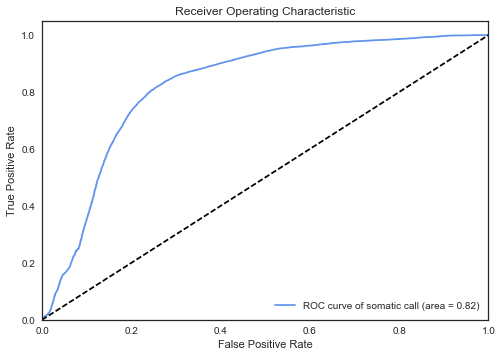

In [33]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00210294  0.00465958  0.00457954  0.00477698  0.00578468  0.00733099
  0.00819355  0.0086304   0.00767087  0.00503957]


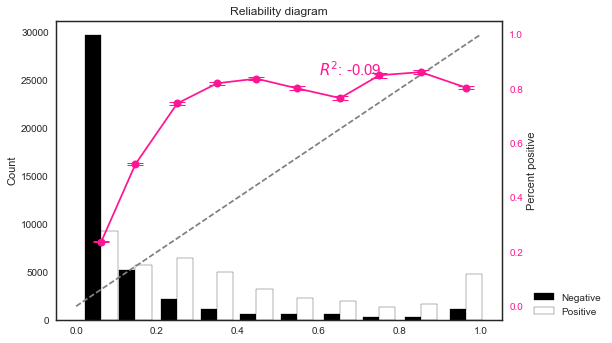

In [34]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'deeppink')

# Somatic, ambigous, fail classifier

In [7]:
three_class = training_data.replace('g', 'f')
three_class.call.value_counts()

s    21156
a    14589
f     5909
Name: call, dtype: int64

In [8]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [9]:
X.shape

(41654, 71)

In [10]:
Y.shape

(41654, 3)

In [11]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [12]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
if not os.path.exists('../data/log_reg/threeclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/threeclass_relu_probs.npy')

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.75493349978393431

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.73      0.66      0.70     14589
          1       0.60      0.66      0.63      5909
          2       0.82      0.84      0.83     21156

avg / total       0.76      0.75      0.75     41654



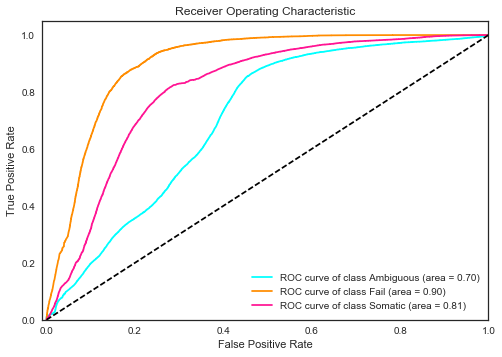

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'deeppink', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00127809  0.00394568  0.0056964   0.00669435  0.0069126   0.00783494
  0.00816708  0.00998142  0.00819338  0.0057043 ]


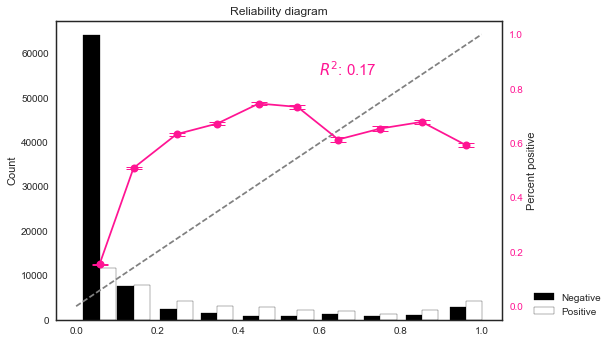

In [20]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'deeppink')